## **Team 5**
CHERNYSHOVA Maria<br>
EDORH Valex<br>
FINO Thomas<br>
SBAI Ilyas


Assignment :
- Take the  FRED-MD data and merge it with Goyal-Welch data
- Use the machine learning methods from the class to study performance of trading strategies based on these data:
  - Build strategies based on random features, investigate the role of activation function (to build random features), scale ($\gamma$), and ridge penalty
  - Build deep neural networks in Pytorch and study the role of depth, learning rate, and weight decay.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
pd.options.display.float_format = '{:,.2f}'.format

## Clean the data

In [ ]:
# Import FRED-MD data and Goyal-Welch data
import os
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/macro_data'

goyal_welch_data = pd.read_csv(os.path.join(folder,'GoyalWelchPredictorData2022Monthly.csv'), index_col=0)
goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')

fred_data = pd.read_csv(os.path.join(folder,'FRED_MD.csv'), index_col=0).iloc[1:, :]
fred_data.index = pd.to_datetime(fred_data.index)

for column in goyal_welch_data.columns:
    goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Compute the returns and excess returns of the index
goyal_welch_data['returns'] = ((goyal_welch_data.Index)/ goyal_welch_data.Index.shift(1) - 1).fillna(0)
goyal_welch_data['excess_returns'] = goyal_welch_data.returns - goyal_welch_data.Rfree

# Keep the data after 1975, drop the csp column, fill the missing values with zeros
goyal_welch_data = goyal_welch_data.loc['1975':].drop(columns=['csp']).fillna(0)

In [ ]:
# Merge FRED-MD and Goyal-Welch data
combined_df = pd.concat([fred_data, goyal_welch_data], axis=1)
combined_df.dropna(inplace=True)

In [ ]:
combined_df.head()

RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx    RETAILx  INDPRO  \
1992-02-01 8,444.99 7,290.10            49.12 718,889.12 164,213.00   61.93   
1992-03-01 8,457.39 7,294.40            49.21 721,782.60 163,721.00   62.45   
1992-04-01 8,487.78 7,313.20            49.25 726,592.64 164,709.00   62.93   
1992-05-01 8,531.93 7,352.40            49.51 720,270.97 165,612.00   63.14   
1992-06-01 8,566.72 7,384.20            49.64 727,863.94 166,077.00   63.17   

            IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...  ntis  Rfree  infl   ltr  \
1992-02-01    70.42    68.65    80.30     57.84  ...  0.03   0.00  0.00  0.01   
1992-03-01    71.02    69.26    81.02     59.03  ...  0.04   0.00  0.01 -0.01   
1992-04-01    71.55    69.79    81.78     60.13  ...  0.04   0.00  0.00  0.00   
1992-05-01    71.94    70.20    82.31     62.01  ...  0.04   0.00  0.00  0.02   
1992-06-01    71.77    69.98    81.92     61.15  ...  0.04   0.00  0.00  0.02   

            corpr  svar  CRSP_SPvw  CRSP_SPvwx  returns  excess_returns  
1992-02-01   0.01  0.00       0.01        0.01     0.01            0.01  
1992-03-01  -0.01  0.00      -0.02       -0.02    -0.02           -0.03  
1992-04-01   0.00  0.00       0.03        0.03     0.03            0.02  
1992-05-01   0.03  0.00       0.00        0.00     0.00           -0.00  
1992-06-01   0.02  0.00      -0.02       -0.02    -0.02           -0.02  

[5 rows x 145 columns]

In [ ]:
def normalize(data: np.ndarray,
              ready_normalization: dict = None,
              use_std: bool = False)->tuple:
  """ Function to normalise the data, using either the mean and standard deviation, or the max/min"""

  if ready_normalization is None:
      data_std = data.std(0)
      data_mean = data.mean(0)
      if use_std:
        data = (data - data_mean) / data_std
      else:
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
  else:
      data_std = ready_normalization['std']
      data_mean = ready_normalization['mean']
      if use_std:
        data = (data - data_mean) / data_std
      else:
        data_max = ready_normalization['max']
        data_min = ready_normalization['min']

  data = data - data_min
  data = data/(data_max - data_min)
  data = data - 0.5
  normalization = {'std': data_std,
                   'mean': data_mean,
                    'max': data_max,
                    'min': data_min}

  return data, normalization

In [ ]:
def split_norm_data(cut, tensor: bool = True):

  split = int(signals.shape[0] *cut)

  signals[:split, :], normalization_based_on_train = normalize(signals[:split], use_std=False)
  signals[split:, :] = normalize(signals[split:, :],
                                     ready_normalization=normalization_based_on_train)[0]

  X_train = signals[:split, :]
  X_test = signals[split:, :]
  y_train = labels[:split]
  y_test = labels[split:]
  test_dates = combined_df.excess_returns.index[split:]

  if not(tensor):
    return X_train, X_test, y_train, y_test, test_dates

  else:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create TensorDatasets and DataLoaders for training and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    return train_dataset, test_dataset, test_dates

In [ ]:
# Select signals
signal_columns = combined_df.drop(columns = ["Index", "returns", "excess_returns"]).columns

lag = 1
data_for_signals = combined_df[signal_columns].shift(lag).fillna(0)
signals = data_for_signals.values

# Select labels
labels = combined_df.excess_returns.values.reshape(-1, 1)

In [ ]:
# Get train and test data for Random Features

cut = 0.5   # We look at a 50-50 train-test split

X_train, X_test, y_train, y_test, test_dates = split_norm_data(cut, tensor = False)

## Random features

Investigate the role of :
- activation function (to build random features)
- scale ($\gamma$)
- ridge penalty

For each activation function, we study below the impact of different ridge penalties at various scales.

In [ ]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        tmp = eigenvectors.T @ signals
        betas = tmp.T @ intermed
    predictions = future_signals @ betas
    return betas, predictions

In [ ]:
def sharpe_ratio(x):
    return np.round(np.sqrt(12) * x.mean(0) / x.std(0), 2)

In [ ]:
def random_features(scale, activ_fct):

    P = 50000
    d = signals.shape[1] # how many signals

    split = int(signals.shape[0]*cut)

    # Ridge penalties
    shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # Activation function & scale
    random_features = activ_fct(scale, P, d)

    beta_estimate_using_train_sample, oos_predictions_complex = ridge_regr(signals=random_features[:split, :],
                                                                    labels=y_train,
                                                                    future_signals=random_features[split:, :],
                                                                    shrinkage_list=shrinkage_list)

    oos_predictions_complex = pd.DataFrame(oos_predictions_complex, index = combined_df.index[split:], columns = shrinkage_list)

    market_timing_returns_complex = oos_predictions_complex * y_test

    market_timing_returns_complex.columns = [f'{x}_complex' for x in market_timing_returns_complex.columns]

    data = pd.concat([combined_df, market_timing_returns_complex], axis=1)

    tmp = data[['excess_returns'] + list(market_timing_returns_complex.columns)].iloc[split:, :]

    return tmp

In [ ]:
def regression_with_tstats(predicted_variable, explanatory_variables):
    x_ = explanatory_variables
    x_ = sm.add_constant(x_)
    y_ = predicted_variable

    # Newey-West standard errors with maxlags
    z_ = x_.copy().astype(float)
    result = sm.OLS(y_.values, z_.values).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
    try:
        tstat = np.round(result.summary2().tables[1]['z'], 1)  # alpha t-stat (because for 'const')
        tstat.index = list(z_.columns)
    except:
        print(f'something is wrong for t-stats')
    return tstat

### **Non-linear cos & sin activation function**

We compute random weights matrix as :
$$ \omega = \gamma * \sqrt{\frac{2}{d}} * R $$

where R is a standard normal random matrix of size P × d, and d is the number of signals.

$\gamma$ is a parameter that controls the scale of the our features.

Our random features are then calculated as: <br>
$$ \sqrt{2} * sin(S⋅\omega^{T}) + \sqrt{2} * cos(S⋅\omega^{T})$$

In [ ]:
def activ_fct_1(scale, P, d):

  # Random matrix
  np.random.seed(42)
  omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)

  # Activation function
  ins_sin = np.sqrt(2) * np.sin(signals @ omega.T)
  ins_cos = np.sqrt(2) * np.cos(signals @ omega.T)
  random_features = np.append(ins_sin, ins_cos, axis=1)
  return random_features

In [ ]:
# Generating scale parameters between 1 and 10
scale_list = np.arange(1, 11)

# Using the cos-sin activation function defined previously
activ_fct = activ_fct_1

res_RF = {}
sr_RF = {}

# Running the regression for the 10 scale parameters
for s in scale_list:
  res_RF[s] = random_features(s, activ_fct)
  sr_RF[s] = sharpe_ratio(res_RF[s])

In [ ]:
print("Sharpe ratio of the strategy for different ridge penalties at different scales :\n")
pd.DataFrame(sr_RF)

Sharpe ratio of the strategy for different ridge penalties at different scales :



1     2     3     4     5     6     7     8    9     10
excess_returns  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37 0.37  0.37
1e-08_complex   0.22  0.51  0.18 -0.07  0.12  0.12  0.17  0.59 0.49  0.30
1e-05_complex   0.22  0.51  0.18 -0.07  0.12  0.12  0.17  0.59 0.49  0.30
0.0001_complex  0.23  0.51  0.18 -0.07  0.12  0.12  0.17  0.59 0.49  0.30
0.001_complex   0.26  0.51  0.18 -0.07  0.12  0.12  0.17  0.59 0.49  0.30
0.01_complex    0.26  0.51  0.16 -0.07  0.12  0.12  0.17  0.59 0.49  0.30
0.1_complex     0.05  0.47  0.02 -0.11  0.11  0.11  0.16  0.59 0.49  0.30
1.0_complex    -0.48 -0.23 -0.25 -0.25  0.04 -0.01  0.14  0.59 0.50  0.29
10.0_complex   -0.32 -0.41 -0.37 -0.34 -0.13 -0.24  0.02  0.59 0.55  0.25
100.0_complex  -0.05 -0.40 -0.38 -0.34 -0.24 -0.34 -0.19  0.33 0.41  0.07
1000.0_complex -0.20 -0.35 -0.34 -0.31 -0.29 -0.34 -0.25 -0.01 0.01 -0.16

**Observations** :
- Only for three scales does the SR outperforms that of Excess returns : scales 2, 8 and 9
- Across all scales, smaller ridge penalties generally perform better : from 1e-08 to 0.01
- Scale performance is non-linear : the SR is decreasing & increasing similarly to the shape to its activation function when we increase the scale number
  - best for scales 2, 8, 9
  - 2nd best for scales 1, 3, 10
  - 3rd best for scales 5, 6, 7
  - worst for scale 4


Scale =  2


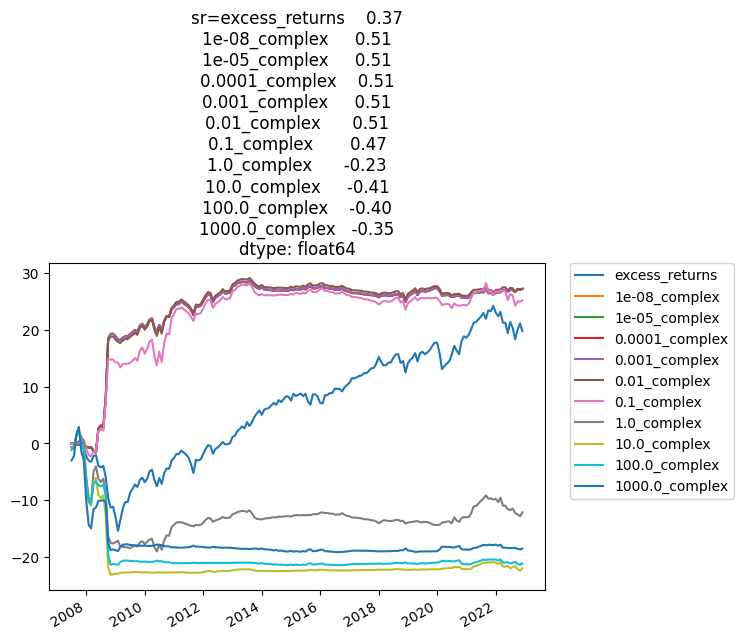


Scale =  8


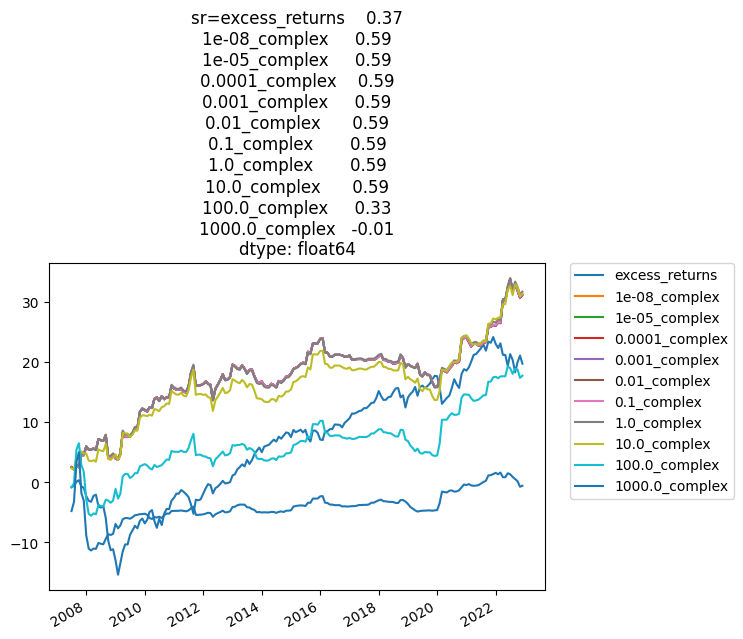


Scale =  9


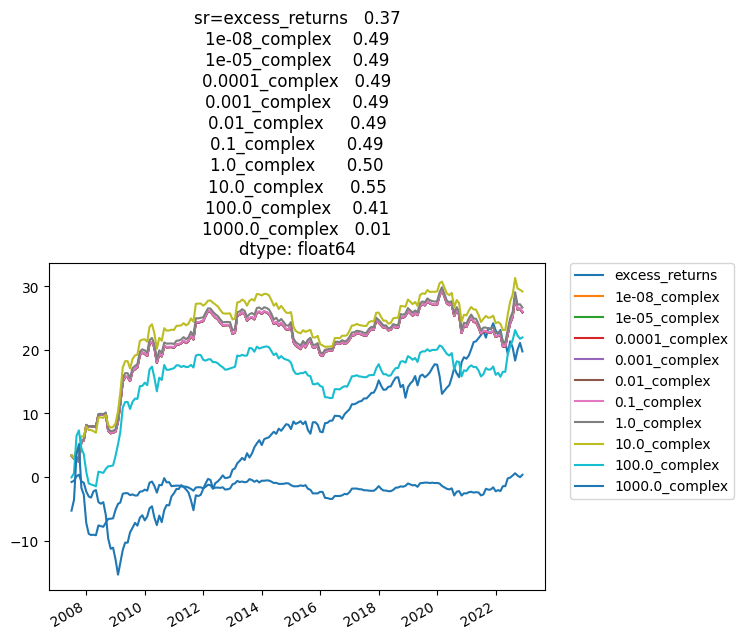

In [ ]:
# Plot the results for the best performing strategies

chosen_scales = [2, 8, 9]

for s in chosen_scales:
    print("\nScale = ", s)

    tmp = res_RF[s]
    sr = sr_RF[s]
    tmp = tmp / tmp.std()
    tmp.cumsum().plot()
    plt.title(f'sr={sr}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

In [ ]:
# Study the significance of out-performance of the best strategies for ridge penalty 0.001

for s in chosen_scales:
    print("\nScale = ", s)

    tmp = res_RF[s]

    left = tmp["0.001_complex"]
    right = tmp["excess_returns"]

    t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]

    print("T-statistic is : ", t_stat)


Scale =  2
T-statistic is :  -0.5

Scale =  8
T-statistic is :  -0.2

Scale =  9
T-statistic is :  0.1


**Observation** : <br>
Using the 0.001 ridge penalty, the best performing strategies do not significantly out-perform the excess returns out of sample (at 95% confidence level).


### **ReLu activation function**

We compute random weights matrix as :

$$ \omega = \gamma * R $$

where R is a standard normal random matrix of size 2P × d, and d is the number of signals.

$\gamma$ is a parameter that controls the scale of the our features.

Our random features are then calculated as: <br>
$$ \max(S*\omega^{T}, 0)$$

In [ ]:
def activ_fct_2(scale, P, d):
  """ReLu"""
  np.random.seed(42)
  weights = scale * np.random.randn(2*P, d)
  random_features = np.clip(signals@weights.T, a_min=0, a_max=None)
  return random_features

In [ ]:
scale_list = np.arange(1, 11)
activ_fct = activ_fct_2

res_RF2 = {}
sr_RF2 = {}

# Running the regression for the 10 scale parameters
for s in scale_list:
  res_RF2[s] = random_features(s, activ_fct)
  sr_RF2[s] = sharpe_ratio(res_RF2[s])

In [ ]:
print("Sharpe ratio of the strategy for different ridge penalties at different scales :\n")
pd.DataFrame(sr_RF2)

Sharpe ratio of the strategy for different ridge penalties at different scales :



1     2     3     4     5     6     7     8     9     10
excess_returns  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37
1e-08_complex  -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
1e-05_complex  -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
0.0001_complex -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
0.001_complex  -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
0.01_complex   -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
0.1_complex    -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
1.0_complex    -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
10.0_complex   -0.49 -0.48 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47 -0.47
100.0_complex   0.51 -0.04 -0.49 -0.49 -0.48 -0.48 -0.48 -0.47 -0.47 -0.47
1000.0_complex  0.53  0.52  0.51  0.50  0.48  0.25 -0.42 -0.48 -0.49 -0.49

**Observations** :
- We observe a very bad performance overall
- The model only outperforms the Excess returns for very high ridge penalization = 1000
- Except for ridge penalty = 1000, the model performance is constant across different scales
- For ridge penalty = 1000, the performance decreases for higher scales


A high ridge penalty (i.e. strong regularization) penalizes the model for complex solutions. Better results with a high penalty might suggest that our model is overfitting the training data when the penalty is lower.
Therefore, this activation function model does not capture well the patterns in our dataset, leading to a lack of information in the random features.

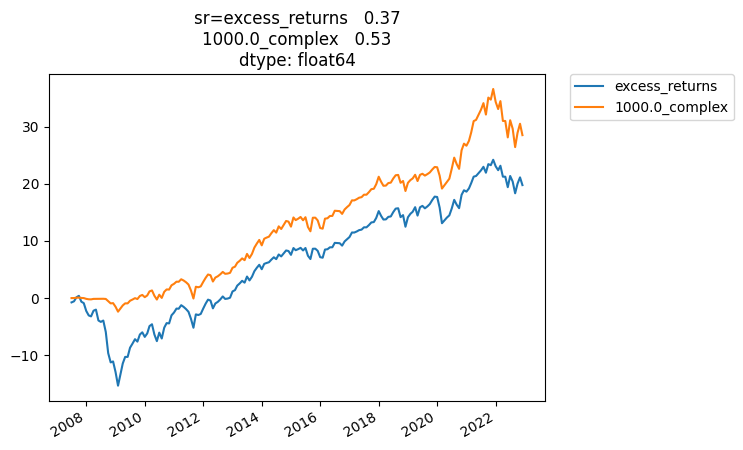

In [ ]:
# Plotting the best strategy alongside the excess returns series
tmp = res_RF2[1][["excess_returns", "1000.0_complex"]]

sr = sharpe_ratio(tmp)

tmp = tmp / tmp.std()
tmp.cumsum().plot()

plt.title(f'sr={sr}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [ ]:
left = tmp["1000.0_complex"]
right = tmp["excess_returns"]

t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]

print("T-statistic is : ", t_stat)

T-statistic is :  4.8


**Observation** : <br>
Using the 1000 ridge penalty, the best performing strategy significantly out-performs the excess returns out of sample.

### **Logistic activation function**

We compute random weights matrix as :

$$ \omega = \gamma * R $$

where R is a standard normal random matrix of size 2P × d, and d is the number of signals.

$\gamma$ is a parameter that controls the scale of the our features.

Our random features are then calculated as: <br>
$$ \frac{1}{1 + exp(-S*\omega^{T})}$$

In [ ]:
def activ_fct_3(scale, P, d):
  """Logistic activation function"""
  np.random.seed(42)
  weights = scale*np.random.randn(2*P, d)

  output = signals @ weights.T

  # Apply logistic activation
  random_features = 1 / (1 + np.exp(-output))

  return random_features

In [ ]:
# Define chosen scale and activation function
scale = 1
activ_fct = activ_fct_3

# Running the regression
res_RF3 = random_features(scale, activ_fct)

# Calculate the Sharpe Ratio
sr_RF3 = sharpe_ratio(res_RF3)

In [ ]:
print("Sharpe ratio of the strategy for different ridge penalties at scales = 1 :\n")
pd.DataFrame(sr_RF3, columns = ["Scale = 1"])

Sharpe ratio of the strategy for different ridge penalties at scales = 1 :



Scale = 1
excess_returns       0.37
1e-08_complex       -0.66
1e-05_complex       -0.66
0.0001_complex      -0.66
0.001_complex       -0.66
0.01_complex        -0.67
0.1_complex         -0.69
1.0_complex         -0.78
10.0_complex         0.34
100.0_complex        0.53
1000.0_complex       0.50

**Observation** : <br>
Once again, the best performances are obtained with a high ridge penalty, indicating that the model fails to capture the patterns in the dataset.

Only when r = 100 and r = 1000 does the strategy outperforms the Excess returns.

**Note** : Here, we only test the performance for scale = 1, as for higher scales there is an overflow in the exponential function.

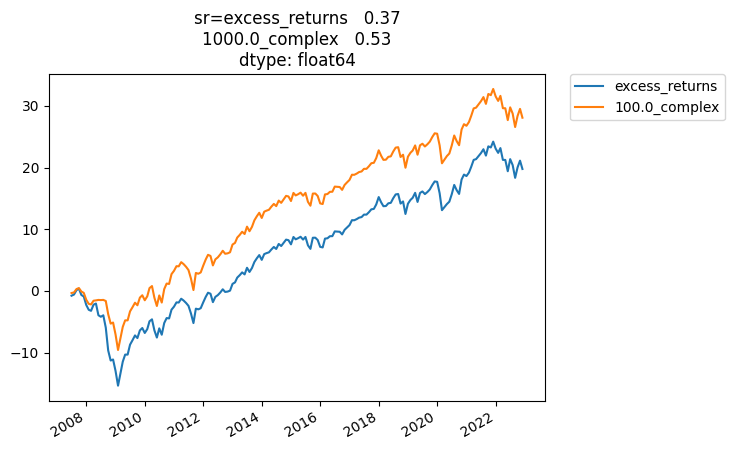

T-statistic is :  14.1


In [ ]:
# Plotting the data of the best performing strategy

tmp = res_RF3[["excess_returns", "100.0_complex"]]

tmp = tmp / tmp.std()

tmp.cumsum().plot()

plt.title(f'sr={sr}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

left = tmp["100.0_complex"]
right = tmp["excess_returns"]

t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]

print("T-statistic is : ", t_stat)

**Observation** : <br>
Using the 100 ridge penalty, the strategy significantly out-performs the Excess returns out of sample.

### **Linear activation function**

Here, we try a simple linear activation function.

We compute random weights matrix as :

$$ \omega = \gamma * R $$

where R is a standard normal random matrix of size 2P × d, and d is the number of signals.

$\gamma$ is a parameter that controls the scale of the our features.

Our random features are then calculated as: <br>
$$ S*\omega^{T}$$

In [ ]:
def activ_fct_4(scale, P, d):
  """Linear activation function"""
  np.random.seed(42)
  weights = scale*np.random.randn(2*P, d)

  random_features = signals @ weights.T

  return random_features

In [ ]:
scale_list = np.arange(1, 11)
activ_fct = activ_fct_4

res_RF4 = {}
sr_RF4 = {}

# Running the regression for the 10 scale parameters
for s in scale_list:
  res_RF4[s] = random_features(s, activ_fct)
  sr_RF4[s] = sharpe_ratio(res_RF4[s])

In [ ]:
print("Sharpe ratio of the strategy for different ridge penalties at different scales :\n")
pd.DataFrame(sr_RF4)

Sharpe ratio of the strategy for different ridge penalties at different scales :



1     2     3     4     5     6     7     8     9     10
excess_returns  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37
1e-08_complex   0.59  0.59  0.61  0.59  0.60  0.63  0.58  0.54  0.62  0.63
1e-05_complex   0.59  0.59  0.59  0.59  0.59  0.59  0.59  0.59  0.60  0.60
0.0001_complex  0.55  0.58  0.59  0.59  0.59  0.59  0.59  0.59  0.59  0.59
0.001_complex   0.51  0.53  0.55  0.56  0.57  0.58  0.58  0.58  0.59  0.59
0.01_complex    0.50  0.50  0.51  0.52  0.52  0.53  0.54  0.54  0.55  0.55
0.1_complex     0.41  0.49  0.50  0.50  0.50  0.50  0.50  0.50  0.51  0.51
1.0_complex    -0.28  0.16  0.39  0.45  0.47  0.48  0.49  0.49  0.50  0.50
10.0_complex   -0.49 -0.41 -0.30 -0.16 -0.02  0.12  0.24  0.32  0.37  0.41
100.0_complex  -0.42 -0.51 -0.49 -0.47 -0.45 -0.42 -0.39 -0.35 -0.32 -0.28
1000.0_complex  0.54  0.50 -0.20 -0.52 -0.52 -0.51 -0.51 -0.50 -0.50 -0.49

In [ ]:
# Mean Sharpe Ratio across various scales
pd.DataFrame(sr_RF4).iloc[1:].mean()

1    0.25
2    0.30
3    0.28
4    0.27
5    0.28
6    0.31
7    0.32
8    0.33
9    0.35
10   0.36
dtype: float64

**Observations** : <br>
- Overall, the linear activation function outperforms the non-linear ones.
- It also outperforms the Excess returns across different scales and ridge penalties, up to a ridge control of 1.0
- The best performances are for smaller ridge penalties : between 1e-08 and 0.1
- Increasing the scale generally increases the Sharpe Ratio, except for very small ridge penalties (1e-08) or very high (1000).


Scale =  9


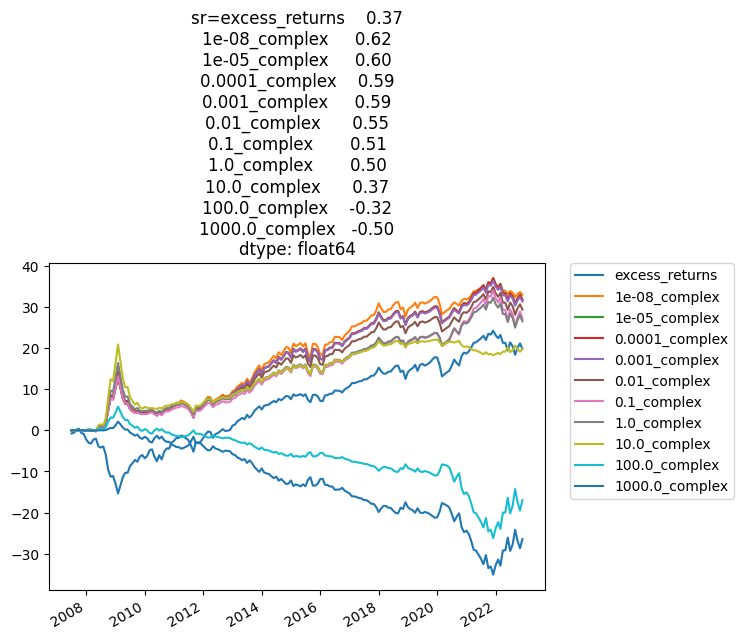


Scale =  10


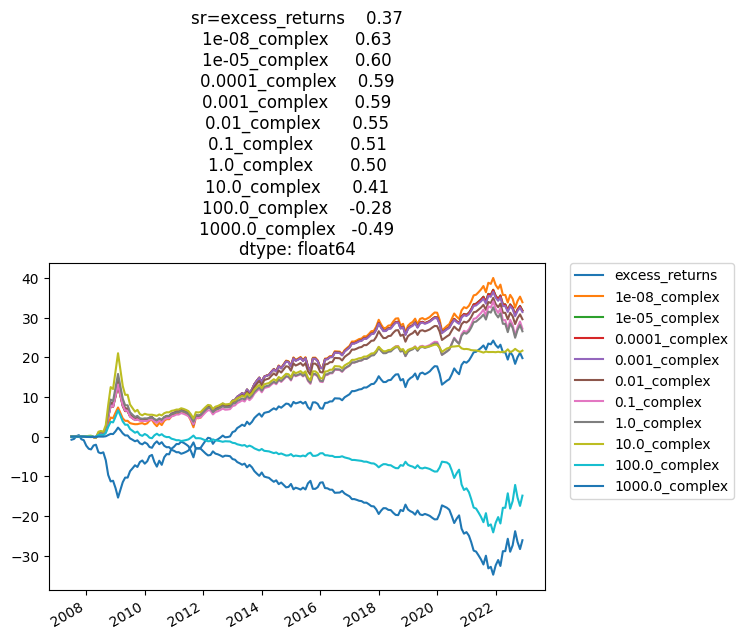

In [ ]:
# Plot the results for the best performing strategies

chosen_scales = [9, 10]

for s in chosen_scales:
    print("\nScale = ", s)

    tmp = res_RF4[s]
    sr = sr_RF4[s]
    tmp = tmp / tmp.std()
    tmp.cumsum().plot()
    plt.title(f'sr={sr}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

In [ ]:
# Study the significance of out-performance for ridge penalty 1e-05

for s in chosen_scales:
    print("\nScale = ", s)

    tmp = res_RF4[s]

    left = tmp["1e-05_complex"]
    right = tmp["excess_returns"]

    t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]

    print("T-statistic is : ", t_stat)


Scale =  9
T-statistic is :  1.3

Scale =  10
T-statistic is :  1.3


**Observation** : <br>
- The best performing strategies outperform excess returns, although not significantly at 95% confidence level.

### **Conclusion**

Across different activation functions that we tested, only non-linear cos-sin and linear activation functions performed well.
Their performance was better with smaller ridge penalties and higher scales.
The linear activation function captures better the patterns in the dataset than the non-linear one. This might be explained by the fact that we take a large number of various signals, so adding more complexity via non-linearity while generating the random features leads to overfitting.

Other activation functions such as ReLu or Logistic only performed well with very high ridge penalties. They are not adapted well to our dataset.


## Neural networks

We first define the necessary functions to run the Neural Network and display the results. <br>
We then study the role of
- depth
- train-test split
- learning rate
- weight decay


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

In [ ]:
class FlexibleMLP(nn.Module):


    def __init__(self, layers):

        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization : initialize weghts from normal
            nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=np.sqrt(1 / layers[i]))

            self.layers.append(layer)

            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Identity())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

    def set_seed(seed_value=42):
      """Set seed for reproducibility."""
      np.random.seed(seed_value)  # Set NumPy seed
      torch.manual_seed(seed_value)  # Set PyTorch seed
      random.seed(seed_value)  # Set Python random seed

      # If you are using CUDA:
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed_value)
          torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
          torch.backends.cudnn.deterministic = True
          torch.backends.cudnn.benchmark = False

In [ ]:
def train_model(num_epochs: int,
                train_loader: DataLoader,
                criterion,
                optimizer,
                model):

  # Training loop
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          # Backward and optimize
          optimizer.zero_grad() # kill old gradients
          loss.backward() # compute new gradients
          optimizer.step() # perform the step of gradient descent

In [ ]:
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

In [ ]:
from typing import List

# Create the Neural net
def neural_net(depth: List[int], lr, weight_decay, train, test):

  train_loader = DataLoader(train, batch_size=64, shuffle=False)
  test_loader = DataLoader(test, batch_size=64, shuffle=False)

  # Initialize the deep neural network model
  num_seeds = 20

  FlexibleMLP.set_seed(42)
  model_architecture = [X_train.shape[1]] + depth + [1]
  models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

  # Loss and optimizer
  for seed in range(num_seeds):

      FlexibleMLP.set_seed(seed)

      criterion = nn.MSELoss()

      optimizer = optim.Adam(models[seed].parameters(), lr = lr, weight_decay = weight_decay)

      train_model(num_epochs=200,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            model=models[seed])

  train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
  test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]

  train_targets = train_sample[0][0]
  train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

  all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
  test_predictions = all_test_predictions.mean(1)
  test_targets = test_sample[0][0]

  return train_predictions, train_targets, test_predictions, test_targets

In [ ]:
def plot_NN(train_predictions, train_targets, test_predictions, test_targets, test_dates):

  # Calculate MSE for both training and test sets
  train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
  test_mse = np.mean((test_targets - test_predictions) ** 2) / np.mean(test_targets ** 2)

  # Plotting
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))

  # Training set subplot
  axs[0].scatter(train_targets, train_predictions)
  axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
  axs[0].set_xlabel('Actual values')
  axs[0].set_ylabel('Predicted values')
  axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

  # Test set subplot
  axs[1].scatter(test_targets, test_predictions)
  axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
  axs[1].set_xlabel('Actual values')
  axs[1].set_ylabel('Predicted values')
  axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

  timed_returns_NN = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns_NN], axis=1), index=test_dates, columns = ["Y test", "Timed rets NN"])

  sr = sharpe_ratio(together)
  fig, ax = plt.subplots(figsize=(6, 5))
  ax.plot((together / together.std()).cumsum(), label=['Cumulative Returns Excess Returns', 'Cumulative Returns NN'])
  ax.legend()
  ax.set_title(f'{sr}')

  plt.tight_layout()
  plt.show()

  return sr, train_mse, test_mse

### **Depth**

**Preliminary studies**

In this part, we increase each time the number of layers by one. We study two different scenarios :
- First, when the number of neurons remains the same within each layer.
- Second, when the number of neurons decreases by half within each new layer added.

For each scenario, we test both 50-50 and 70-30 train-test splits.

We use a learning rate of 0.0001 and a weight decay of 0.

We subsequently choose the most effective method among those evaluated based on factors such as the train-test split and the number of neurons, and continue our studies using the chosen approach.

#### 50-50 train-test split

##### Static number of neurons


Depth: [100]
Learning rate: 0.0001
Weight decay: 0



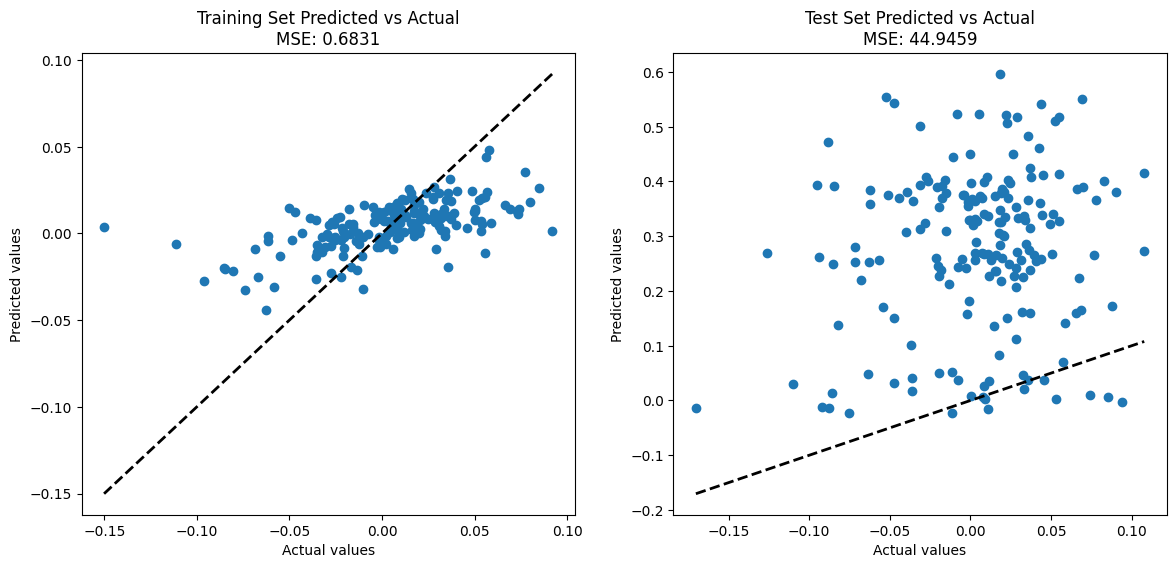

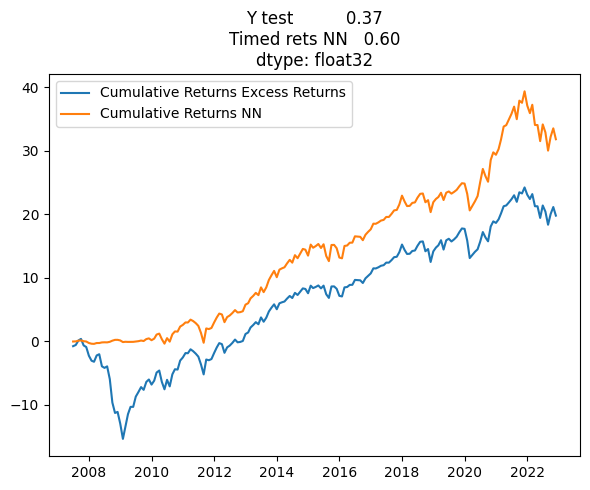


Depth: [100, 100]
Learning rate: 0.0001
Weight decay: 0



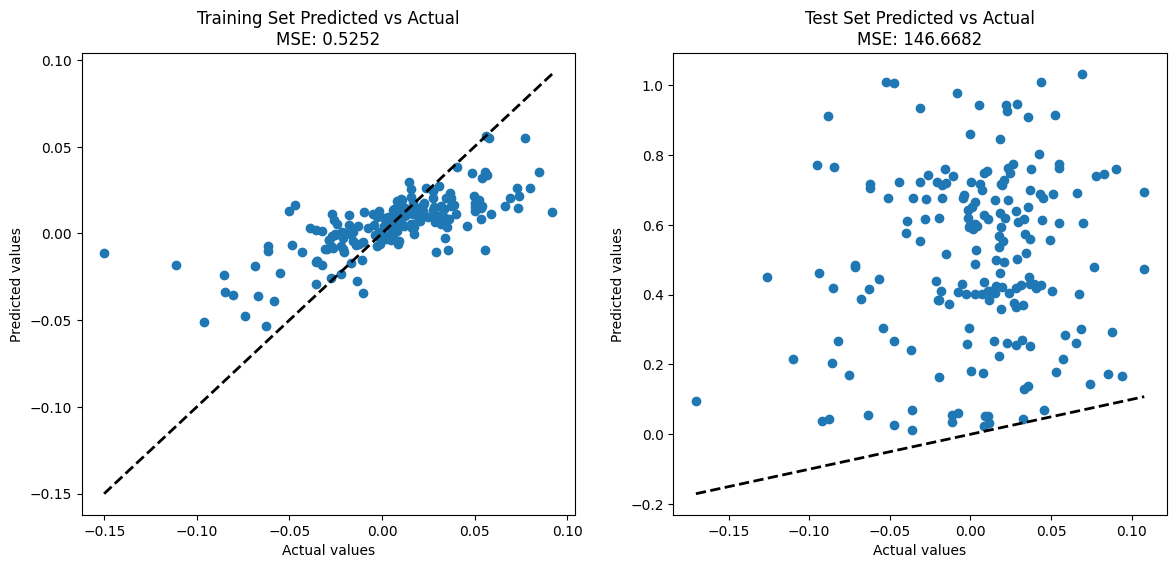

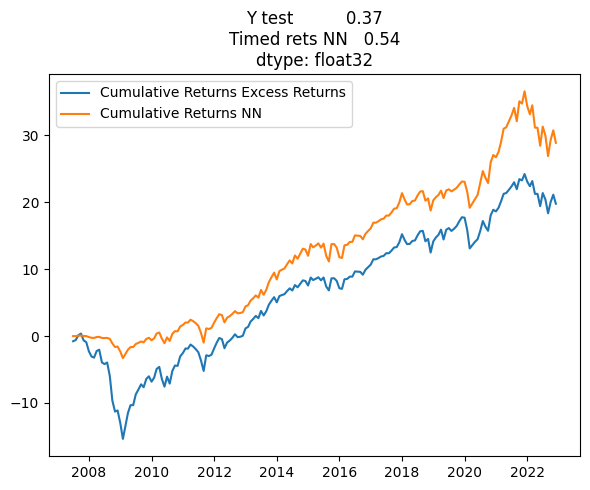


Depth: [100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



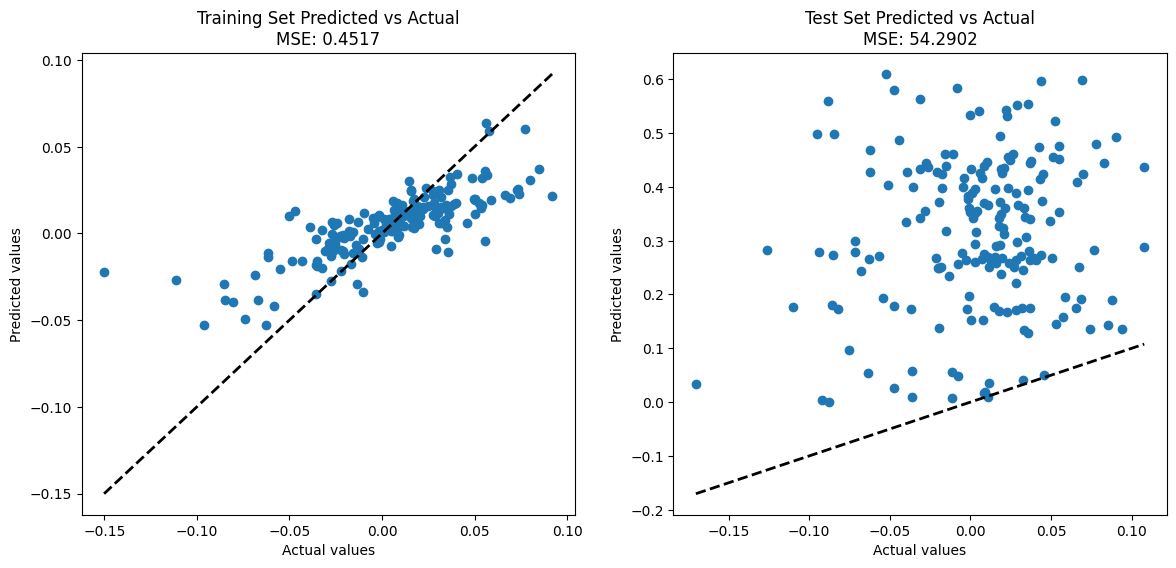

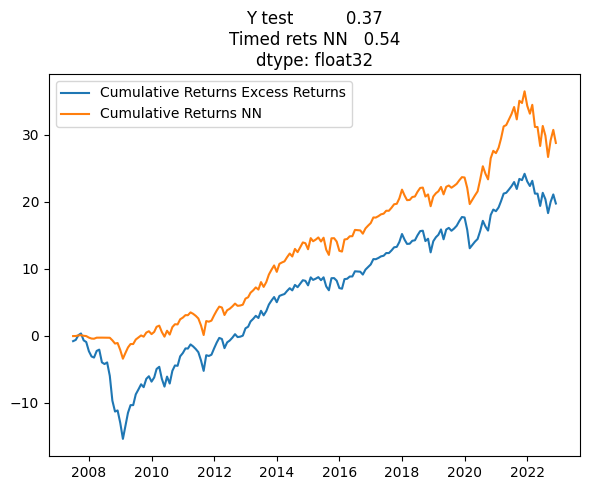


Depth: [100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



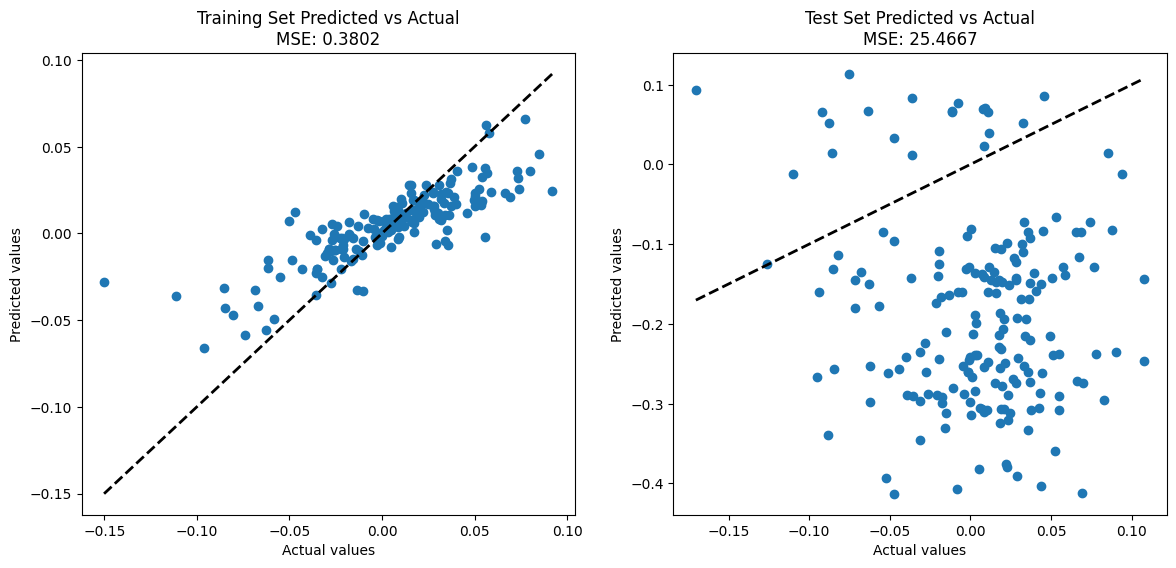

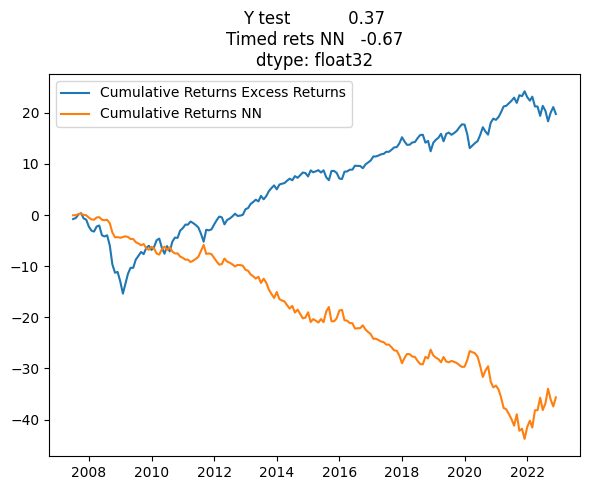


Depth: [100, 100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



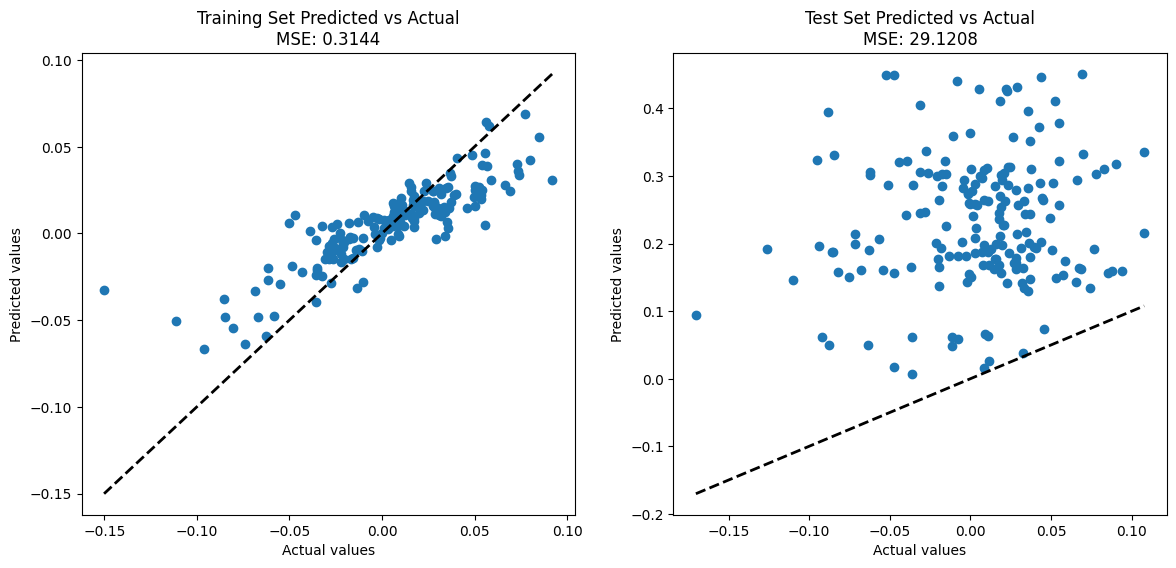

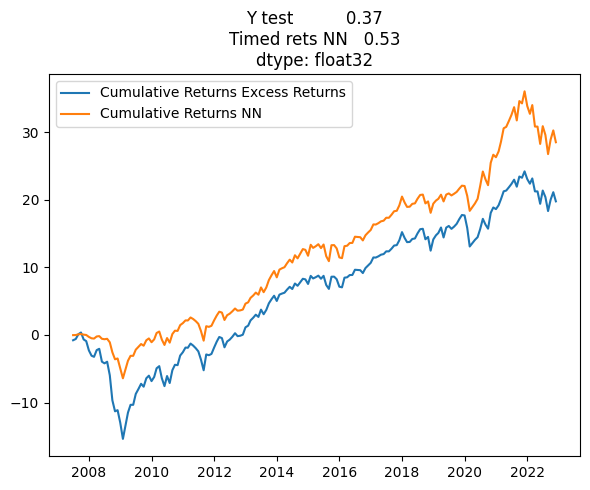


Depth: [100, 100, 100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



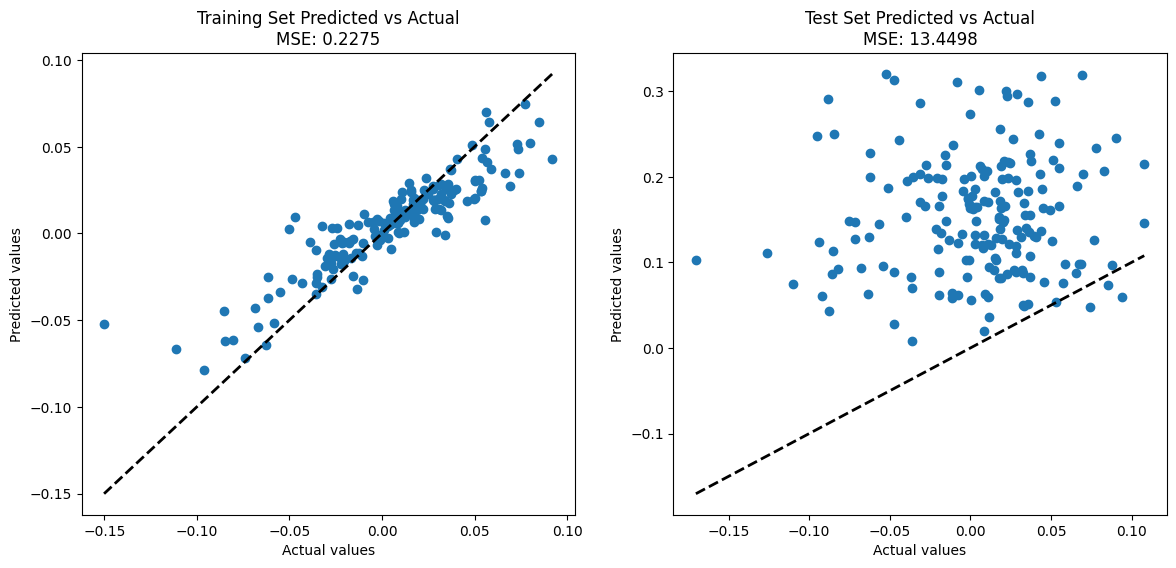

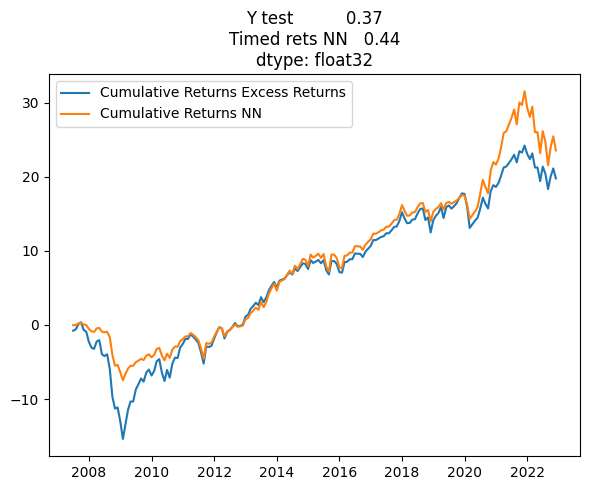

In [ ]:
# Neural Network parameters
lr = 0.0001       # Learning rate
weight_decay = 0
cut = 0.5

# List to store our results
sr_NN1 = []
train_mse1 = []
test_mse1 = []
res_NN1 = {}


# Number of layers  tested, with a constant number of neurons per layer
depth_range = [[100],[100, 100], [100,100,100], [100,100,100,100], [100,100,100,100,100], [100,100,100,100,100,100]]

# Running the neural network for each learning rate
for i, depth in enumerate(depth_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN1[i] = market_timing_returns

  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN1.append(sr)
  train_mse1.append(np.round(train_mse,2))
  test_mse1.append(np.round(test_mse, 2))

In [ ]:
# Concatenating the results
df_5050_static = pd.concat([pd.DataFrame(train_mse1).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse1).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN1).T])
df_5050_static.rename(columns = {0: 1, 1:2, 2:3, 3:4, 4:5, 5:6}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_5050_static

1      2     3     4     5     6
Train MSE          0.68   0.53  0.45  0.38  0.31  0.23
Test MSE          44.95 146.67 54.29 25.47 29.12 13.45
Excess returns SR  0.37   0.37  0.37  0.37  0.37  0.37
Model predict SR   0.60   0.54  0.54 -0.67  0.53  0.44

**Observations**: case where each layer has the same number of neurons

We can observe that
- Overall, the Sharpe ratio of the NN strategy is higher than that of Excess returns, except for 4 layers where it decreases to -0.67
- Addig more layers decreases the Mean Squared error for both train and test data, indicating that the more complex model is fitting the data better without overfitting too much
- However, as the number of layers increases, the Sharpe Ratio of the model decreases

In [ ]:
# Comparing the model predictions with excess returns

chosen_layers = [1, 5, 6]

for lay in chosen_layers :

  print("\nNumber of layers = ", lay)

  left = pd.DataFrame(res_NN1[lay - 1])
  right = res_RF[1]["excess_returns"]

  t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]
  print("T-statistic is : ", t_stat)


Number of layers =  1
T-statistic is :  4.1

Number of layers =  5
T-statistic is :  7.4

Number of layers =  6
T-statistic is :  7.0


**Observation**:
- For the best performing strategies (1, 5 and 6 layers), the NN model outperforms significantly the Excess returns.


##### Decreasing number of neurons
We now keep adding layers, but with a decreasing number of neurons.


Depth: [512]
Learning rate: 0.0001
Weight decay: 0



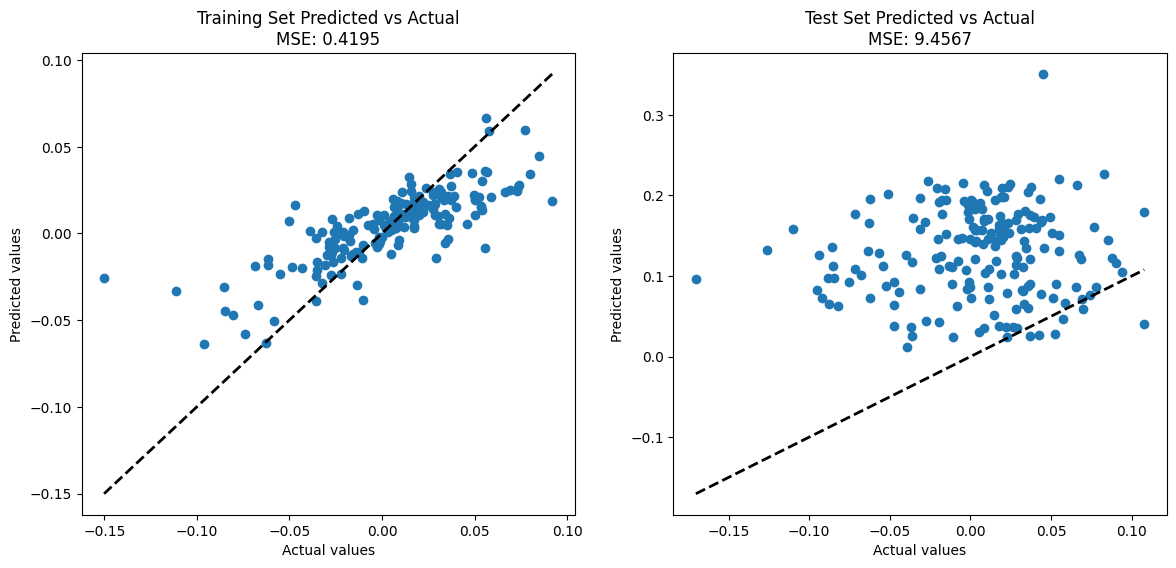

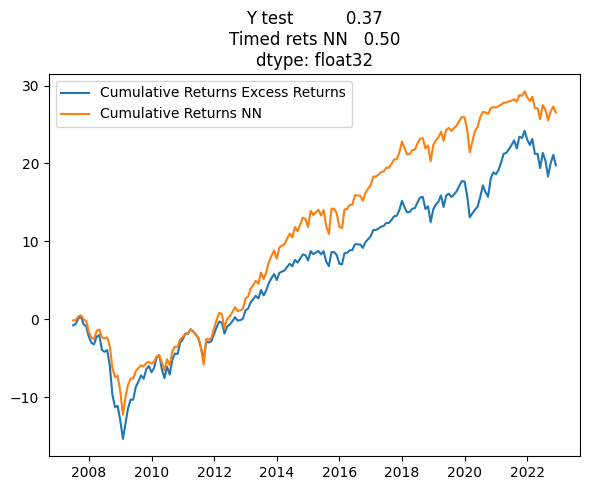


Depth: [512, 256]
Learning rate: 0.0001
Weight decay: 0



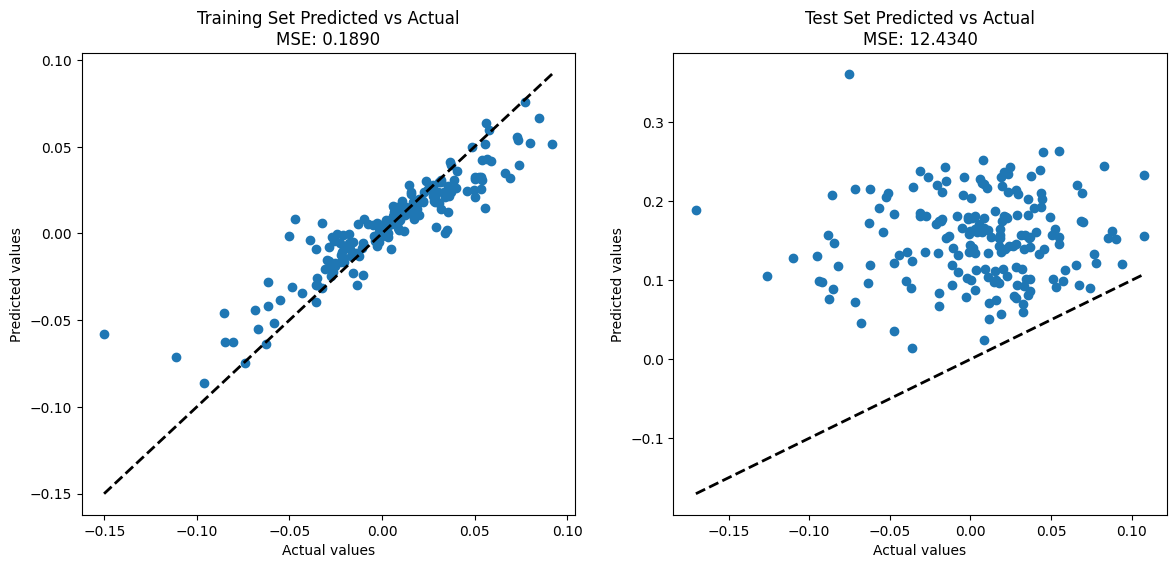

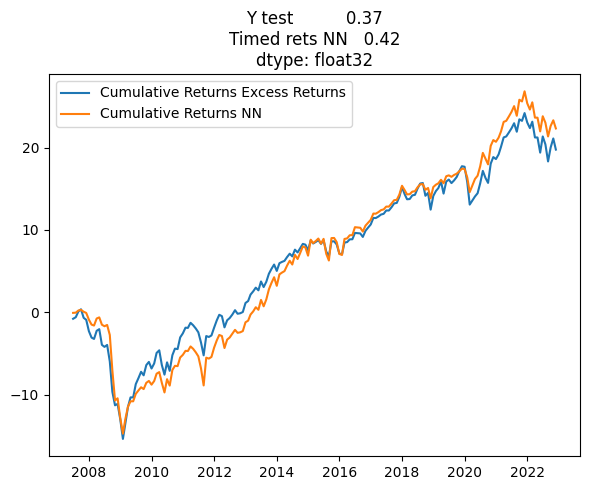


Depth: [512, 256, 128]
Learning rate: 0.0001
Weight decay: 0



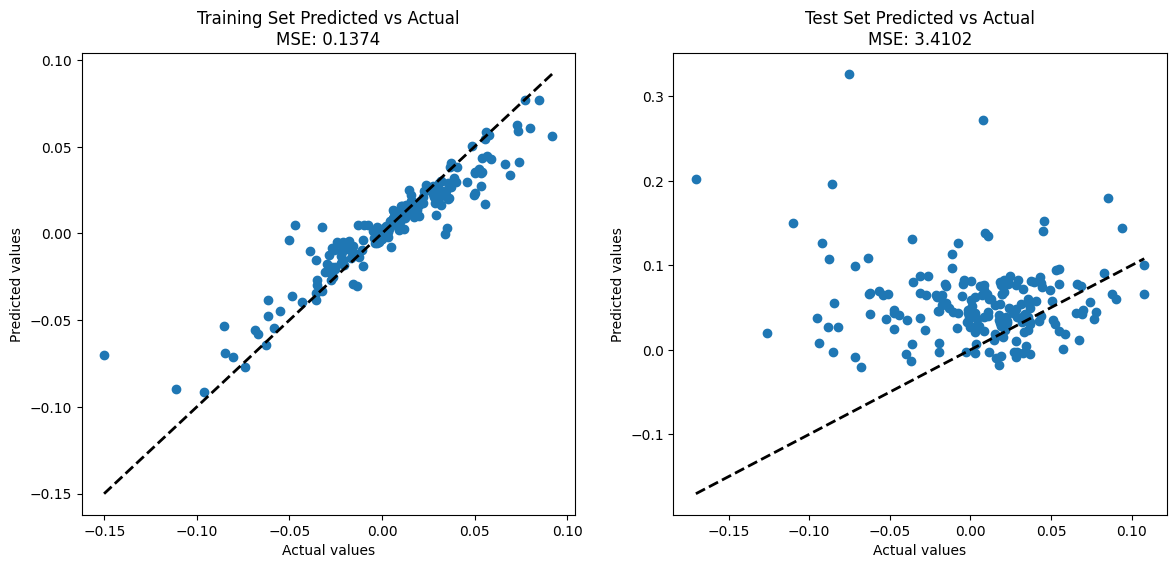

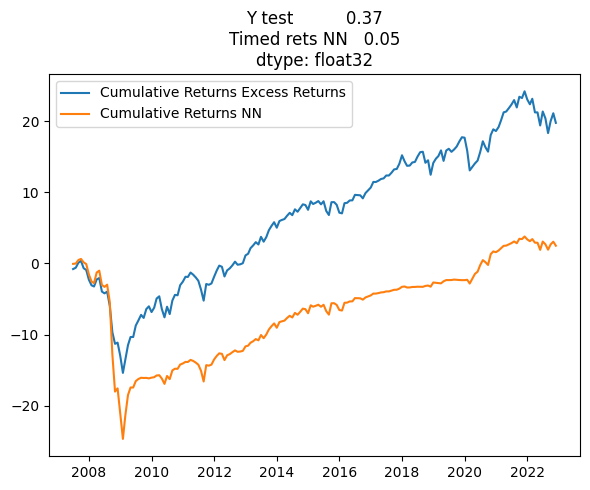


Depth: [512, 256, 128, 64]
Learning rate: 0.0001
Weight decay: 0



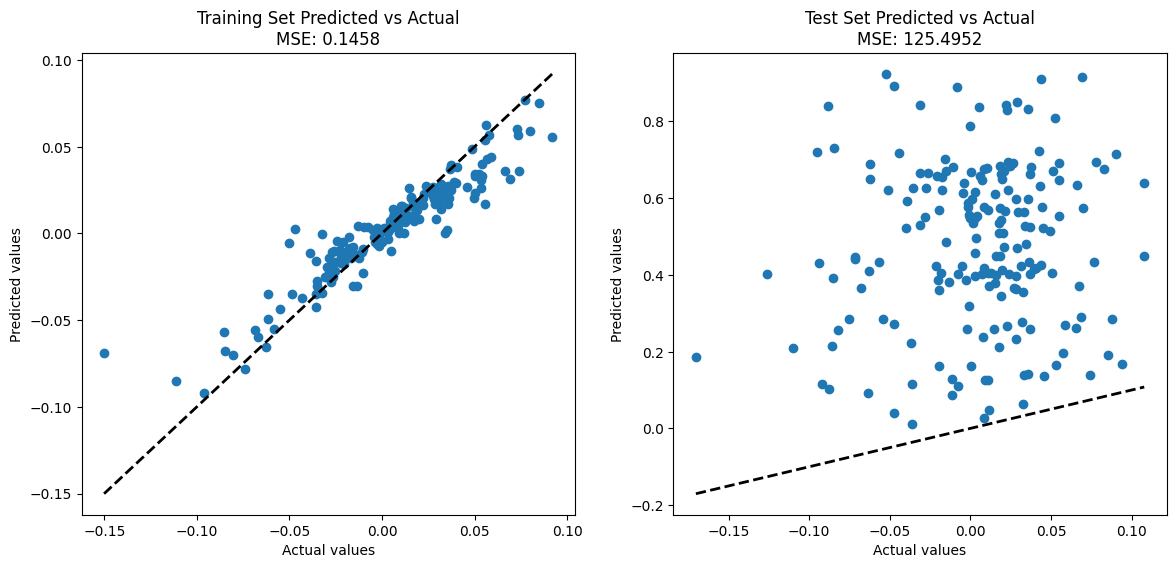

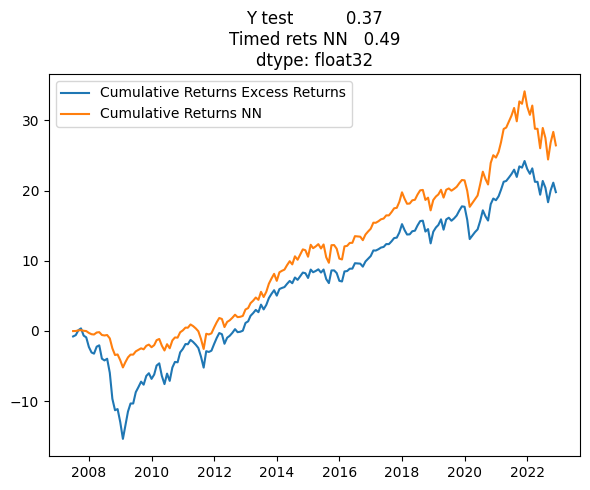


Depth: [512, 256, 128, 64, 32]
Learning rate: 0.0001
Weight decay: 0



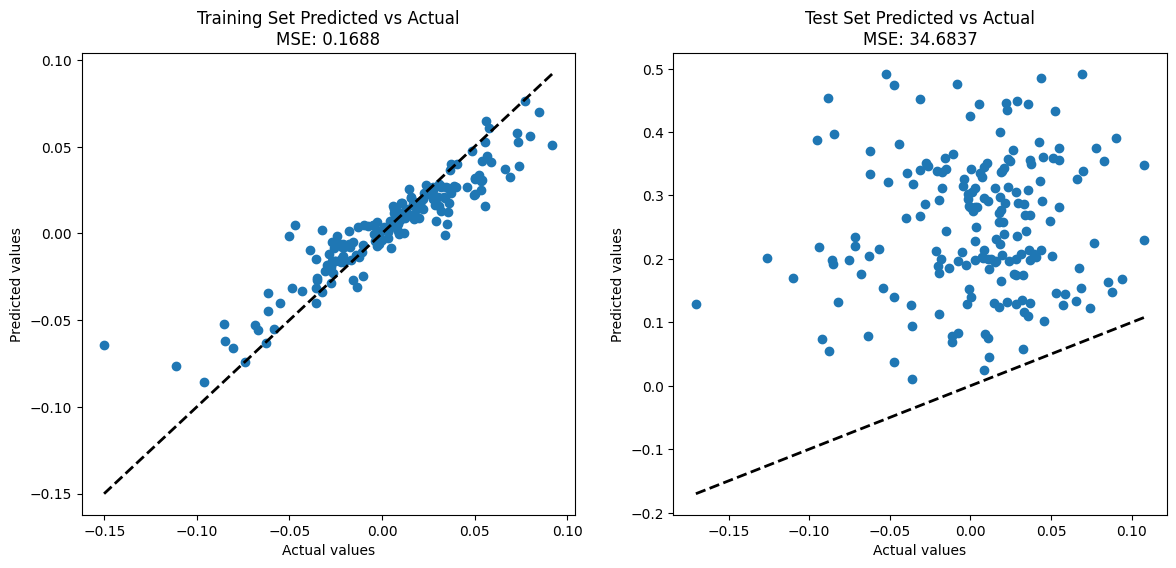

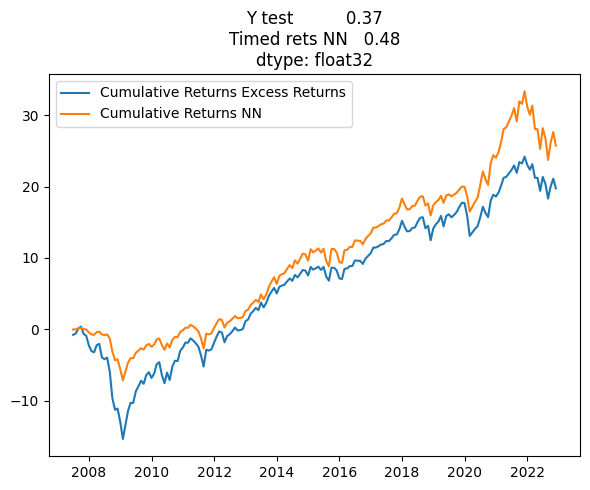


Depth: [512, 256, 128, 64, 32, 16]
Learning rate: 0.0001
Weight decay: 0



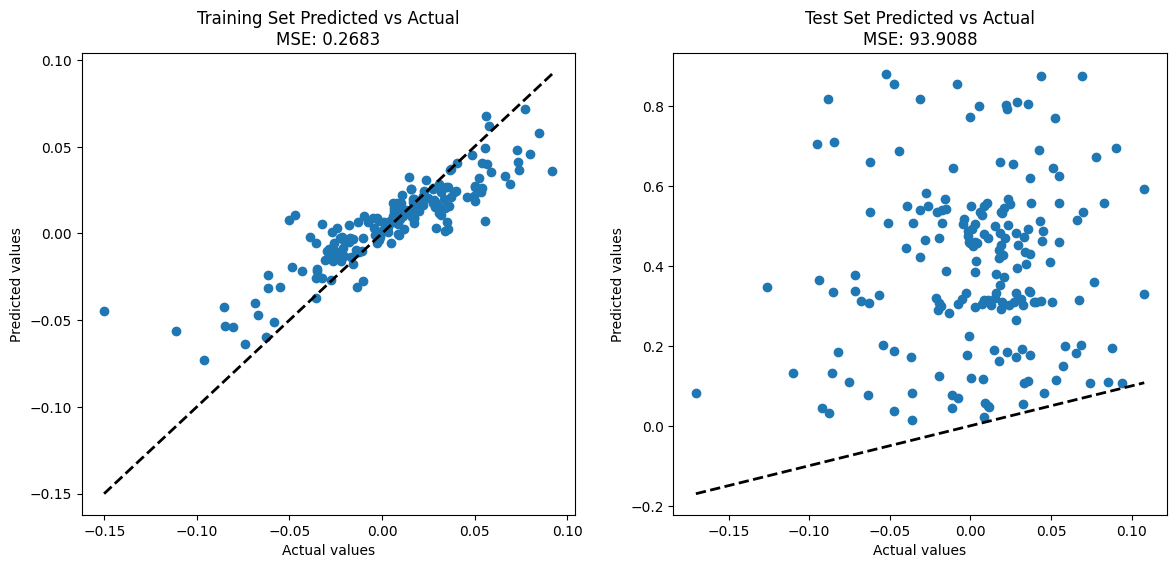

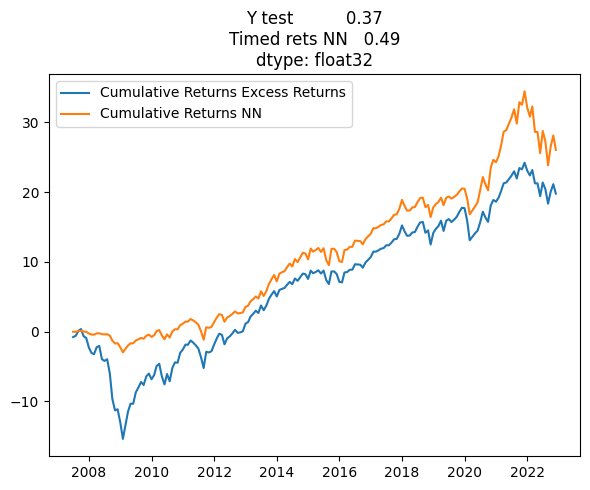

In [ ]:
# Neural Network parameters
lr = 0.0001       # Learning rate
weight_decay = 0
cut = 0.5

# List to store our results
sr_NN2 = []
train_mse2 = []
test_mse2 = []
res_NN2 = {}

# Number of layers with decreasing number of neurons tested
depth_range = [[512],[512, 256], [512,256,128], [512,256,128,64], [512,256,128,64,32], [512,256,128,64,32,16]]

# Running the neural network for each learning rate
for i, depth in enumerate(depth_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN2[i] = market_timing_returns


  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN2.append(sr)
  train_mse2.append(np.round(train_mse,2))
  test_mse2.append(np.round(test_mse, 2))


In [ ]:
# Concatenating the results
df_5050_decr = pd.concat([pd.DataFrame(train_mse2).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse2).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN2).T])
df_5050_decr.rename(columns = {0: 1, 1:2, 2:3, 3:4, 4:5, 5:6}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_5050_decr

1     2    3      4     5     6
Train MSE         0.42  0.19 0.14   0.15  0.17  0.27
Test MSE          9.46 12.43 3.41 125.50 34.68 93.91
Excess returns SR 0.37  0.37 0.37   0.37  0.37  0.37
Model predict SR  0.50  0.42 0.05   0.49  0.48  0.49

**Observations**: case where each new layer has a decreased number of neurons

We can observe that:
- As we increase the number of layers, the train MSE decreases up to a certain point (3 layers), then starts increasing again
- The test MSE is more unstable, with only first 3 depths having a low MSE. This can be explained by the fact that the first layers have a large number of neurons (halved from 512 to 256), hence the first layers are enough to capture the complexity of the model. Adding more layer with lower number of neurons does not contribute much.
- Overall, the model still has a higher Sharpe ratio than that of Excess returns (except for 3 layers)

Comparing with a static number of neurons model:
- Overall, the Sharpe ratio of the static model is higher
- But the MSE is higher too, comparing to the dynamically decreasing number of neurons model

In [ ]:
# Comparing the model predictions with excess returns

chosen_layers = [1, 5]

for lay in chosen_layers :

  print("\nNumber of layers = ", lay)

  left = pd.DataFrame(res_NN2[lay - 1])
  right = res_RF[1]["excess_returns"]

  t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]
  print("T-statistic is : ", t_stat)


Number of layers =  1
T-statistic is :  13.1

Number of layers =  5
T-statistic is :  7.3


In [ ]:
# Comparing the best stratigies of static and dynamic number of neurons models

left = pd.DataFrame(res_NN2[0])   # dynamic model with 1 layer of 512 neurons
right = pd.DataFrame(res_NN1[4])  # static model with 5 layers of 100 neurons

t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)[0]
print("T-statistic is : ", t_stat)

T-statistic is :  5.5


**Observation**:
- The model with 1 layer of 512 neurons significantly outperforms the model with 6 layers of 100 neurons each for the 50/50 split, which suggests that a single layer with a high number of neurons is more effective at capturing the complexity of our dataset.


#### 70-30 train-test split

##### Static number of neurons


Depth: [100]
Learning rate: 0.0001
Weight decay: 0



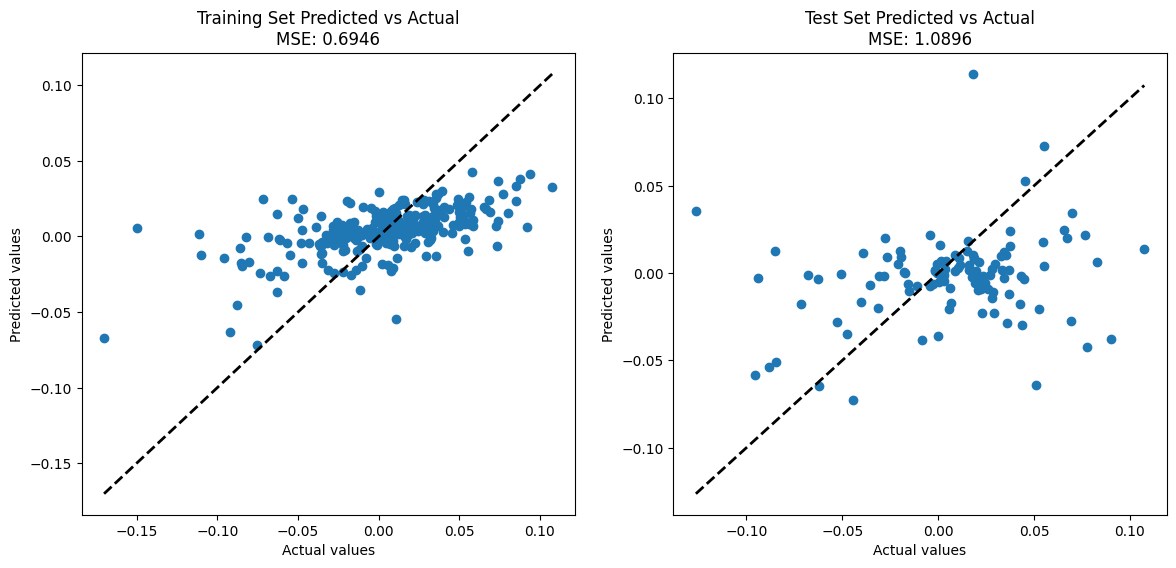

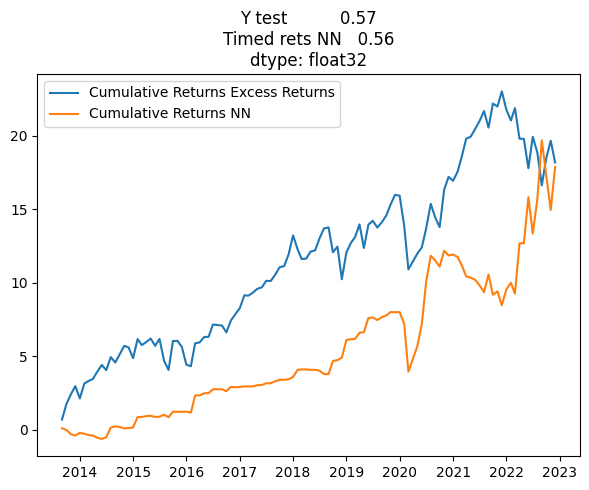


Depth: [100, 100]
Learning rate: 0.0001
Weight decay: 0



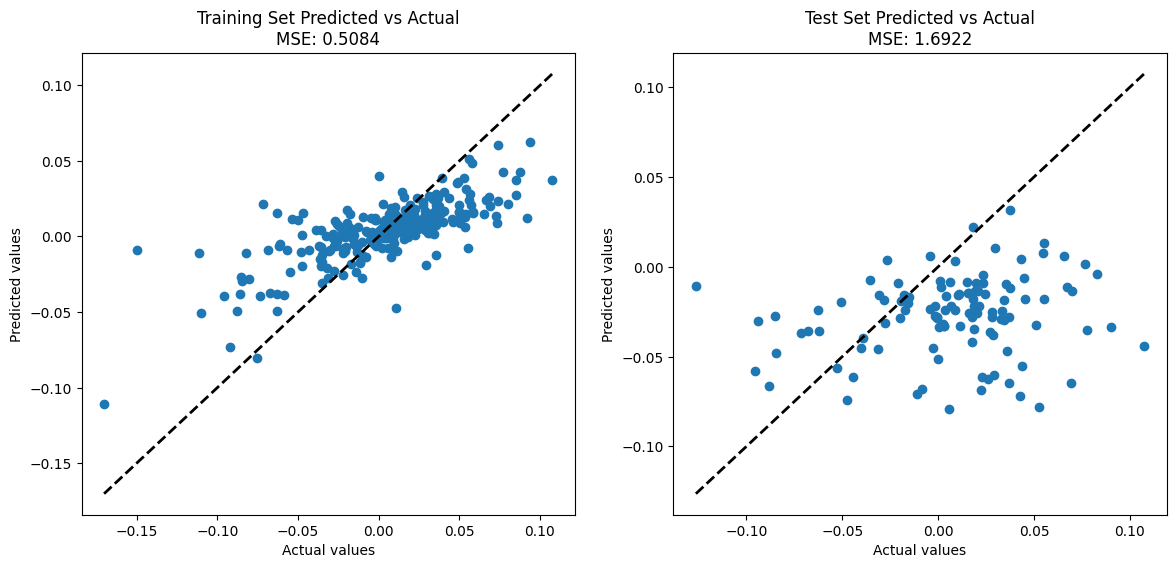

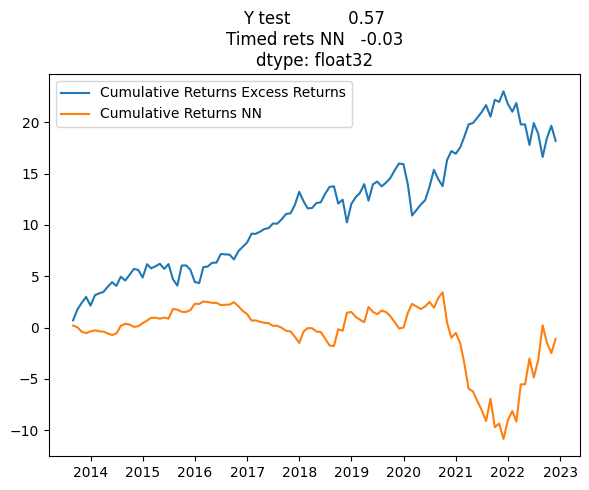


Depth: [100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



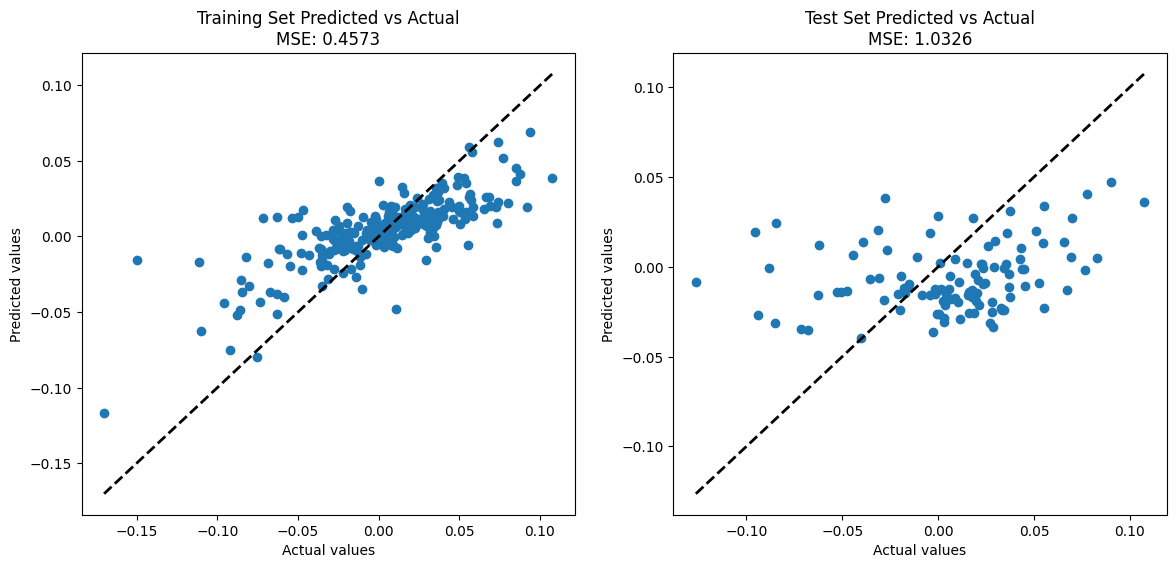

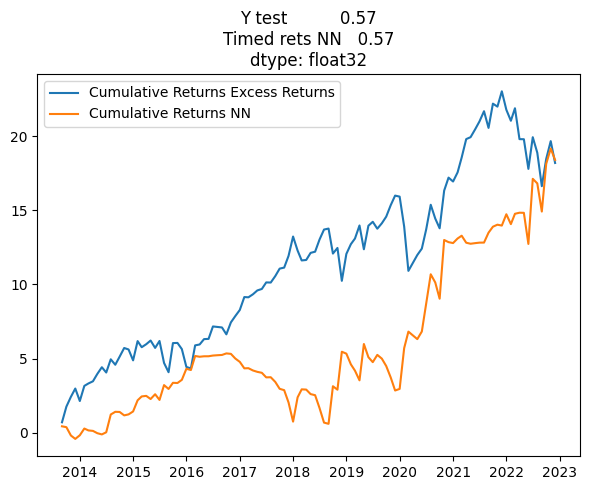


Depth: [100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



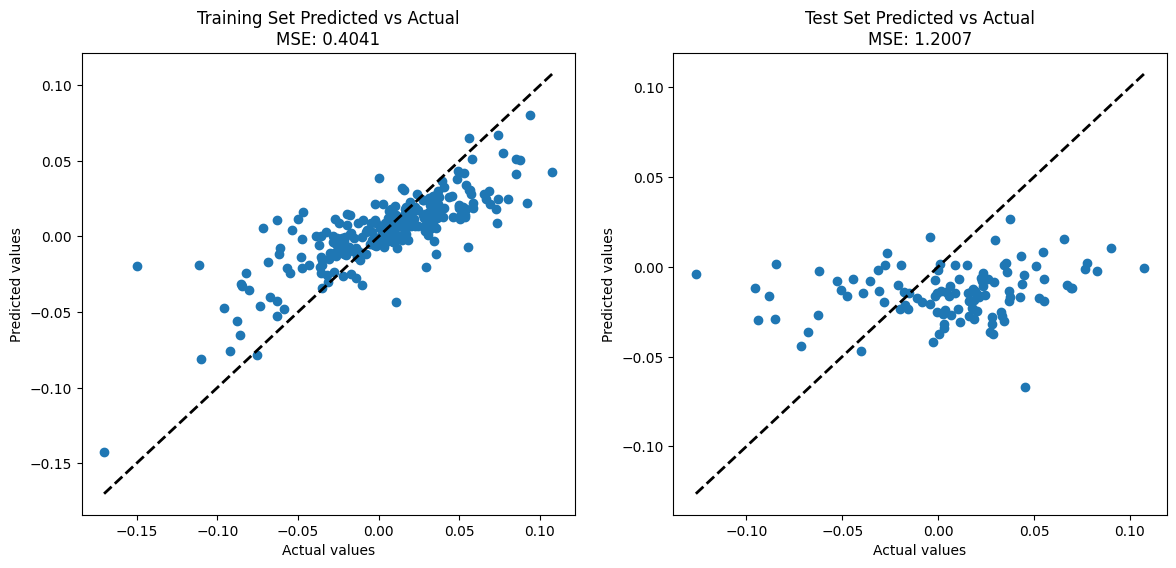

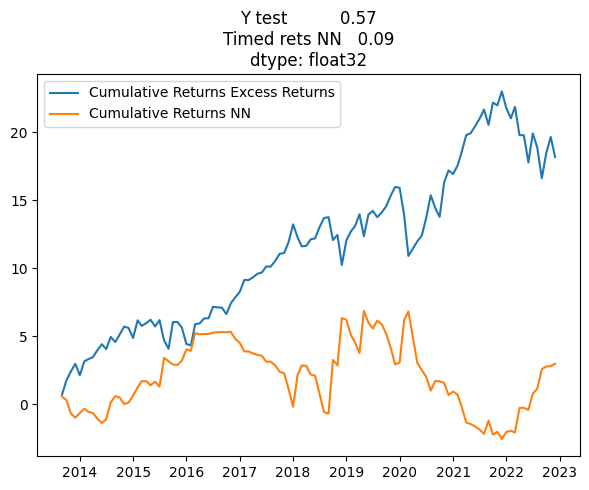


Depth: [100, 100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



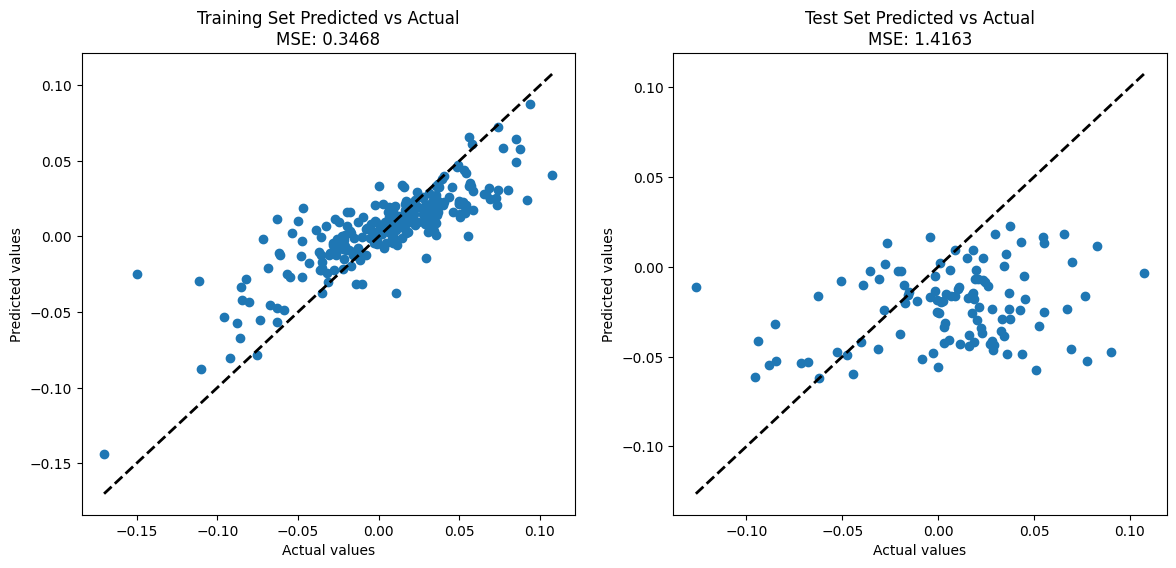

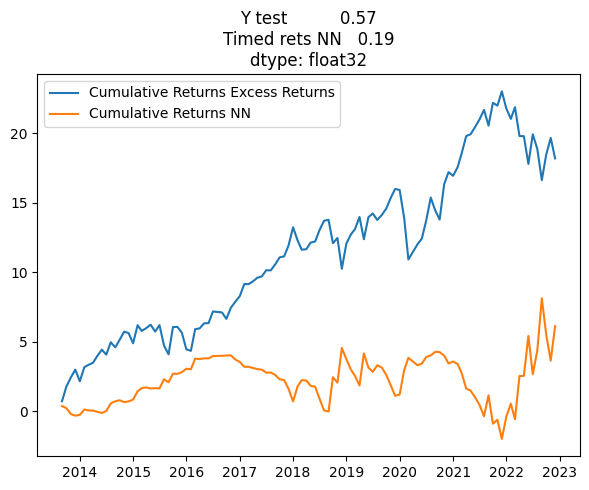


Depth: [100, 100, 100, 100, 100, 100]
Learning rate: 0.0001
Weight decay: 0



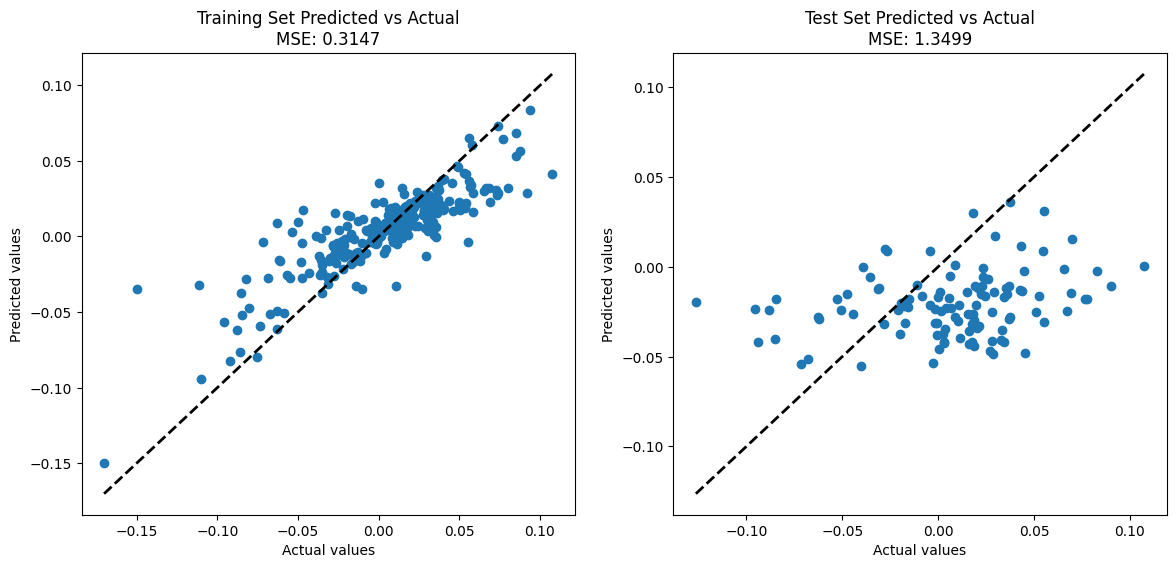

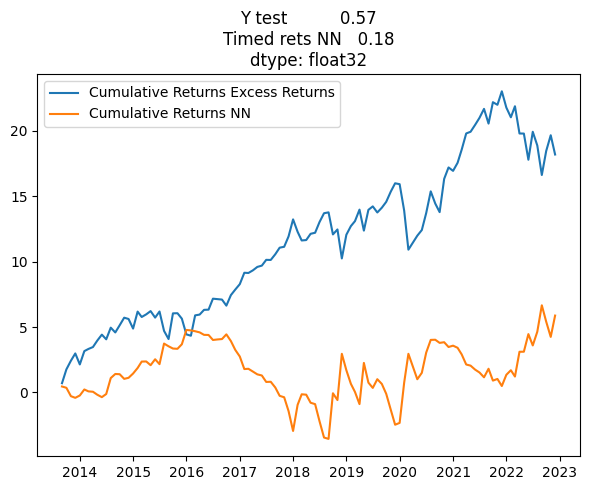

In [ ]:
# Neural Network parameters
lr = 0.0001       # Learning rate
weight_decay = 0
cut = 0.7

# List to store our results
sr_NN3 = []
train_mse3 = []
test_mse3 = []
res_NN3 = {}


# Number of layers  tested, with a constant number of neurons
depth_range = [[100],[100, 100], [100,100,100], [100,100,100,100], [100,100,100,100,100], [100,100,100,100,100,100]]

# Running the neural network for each learning rate
for i, depth in enumerate(depth_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN3[i] = market_timing_returns

  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN3.append(sr)
  train_mse3.append(np.round(train_mse,2))
  test_mse3.append(np.round(test_mse, 2))

In [ ]:
# Concatenating the results
df_7030_static = pd.concat([pd.DataFrame(train_mse3).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse3).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN3).T])
df_7030_static.rename(columns = {0: 1, 1:2, 2:3, 3:4, 4:5, 5:6}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_7030_static

1     2    3    4    5    6
Train MSE         0.69  0.51 0.46 0.40 0.35 0.31
Test MSE          1.09  1.69 1.03 1.20 1.42 1.35
Excess returns SR 0.57  0.57 0.57 0.57 0.57 0.57
Model predict SR  0.56 -0.03 0.57 0.09 0.19 0.18

**Observations**: case where each layer has the same number of neurons

We observe that:
- As in the 50/50 split with static number of neurons, as we increase the number of layers, the train MSE decreases.
- However, contrary to the 50/50 split, as we increase the number of layers, the test MSE increases. This indicates that the model might be overfitting the data, especially since the train split is larger.
- Again, as we increase the number of layers, the SR of the model decreases.



In [ ]:
# Comparing the model predictions with excess returns

split = int(combined_df.shape[0]*cut)
right = combined_df.excess_returns.iloc[split:]

chosen_layers = [1, 3]

for lay in chosen_layers :

  print("\nNumber of layers = ", lay)

  left = pd.DataFrame(res_NN3[lay - 1])

  t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]
  print("T-statistic is : ", t_stat)


Number of layers =  1
T-statistic is :  -0.6

Number of layers =  3
T-statistic is :  0.2


**Observation**:
- The t-statistic gives further confirmation that model with 70-30 train-test split does not outperform the Excess returns.

In [ ]:
# Comparing the 70/30 and 50/50 splits

In [ ]:
df_7030_static.mean(axis=1)

Train MSE           0.45
Test MSE            1.30
Excess returns SR   0.57
Model predict SR    0.26
dtype: float32

In [ ]:
df_5050_static.mean(axis=1)

Train MSE            0.43
Test MSE            52.33
Excess returns SR    0.37
Model predict SR     0.33
dtype: float32

**Observations**:
Comparing the 70/30 and 50/50 split, we observe that
- Although increasing the train/test split leads to lower MSE, it also leads to a much lower Sharpe Ratio, especially w.r.t the corresponding period's excess returns

##### Decreasing number of neurons


Depth: [512]
Learning rate: 0.0001
Weight decay: 0



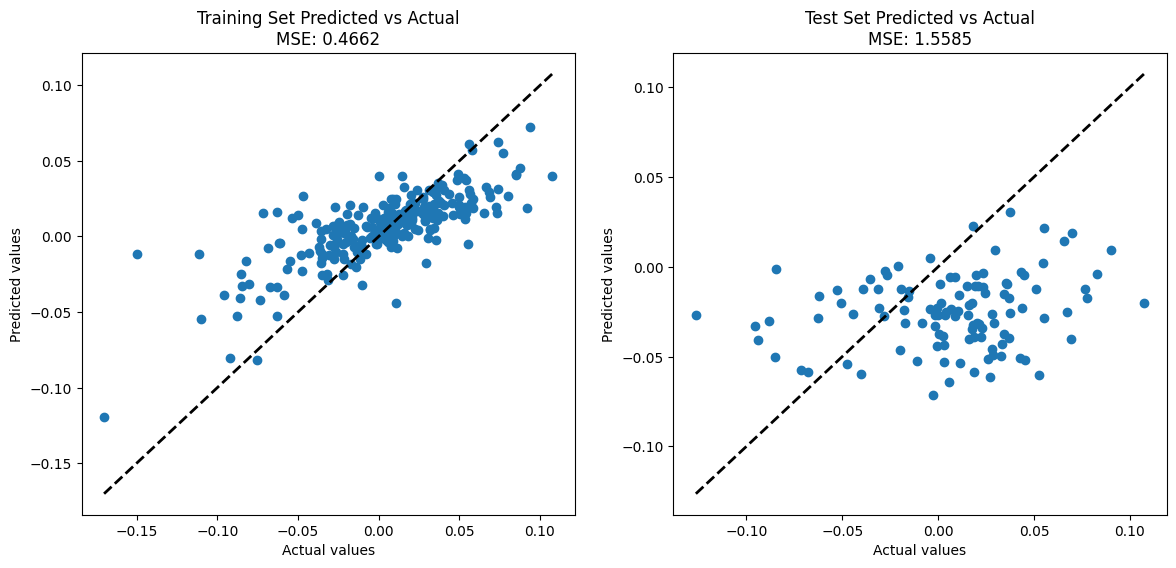

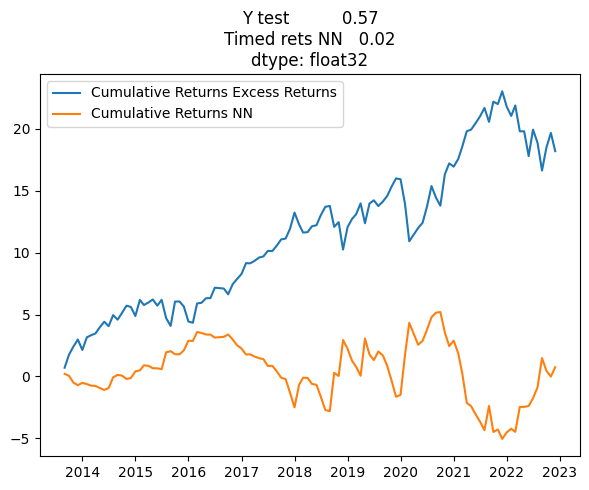


Depth: [512, 256]
Learning rate: 0.0001
Weight decay: 0



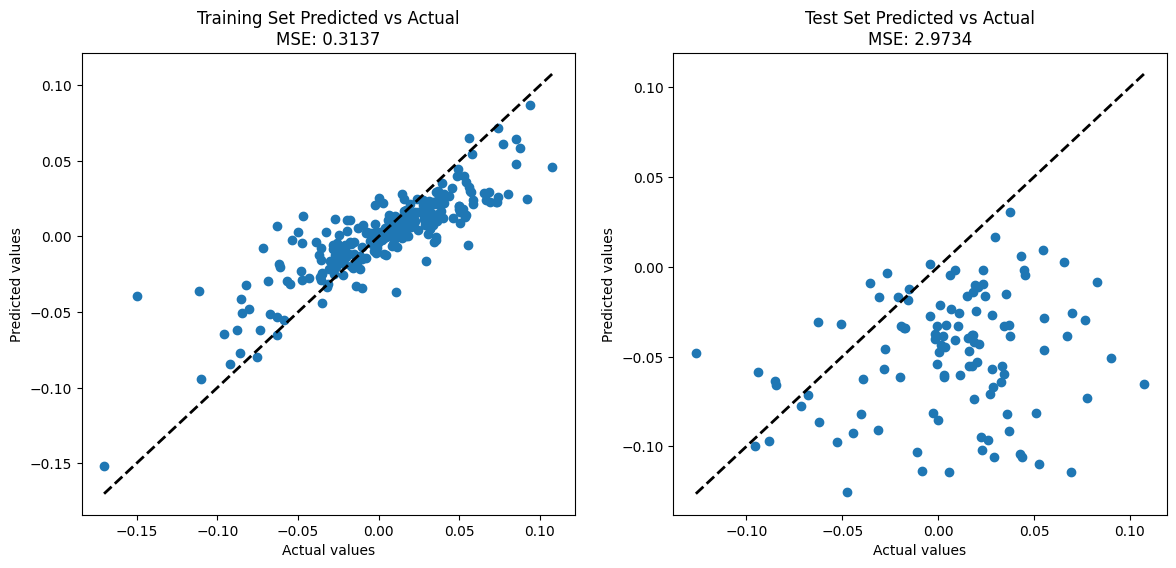

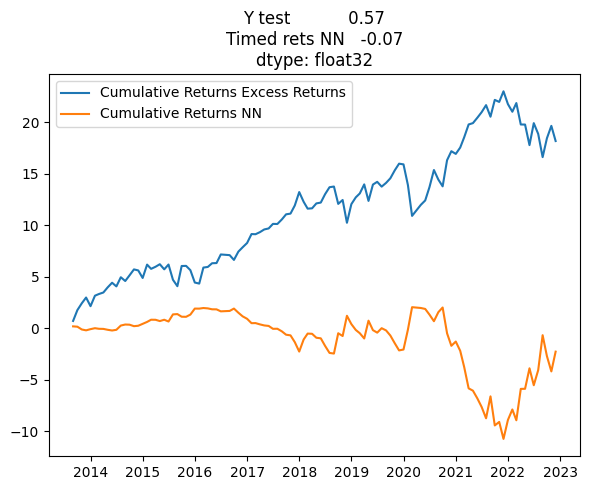


Depth: [512, 256, 128]
Learning rate: 0.0001
Weight decay: 0



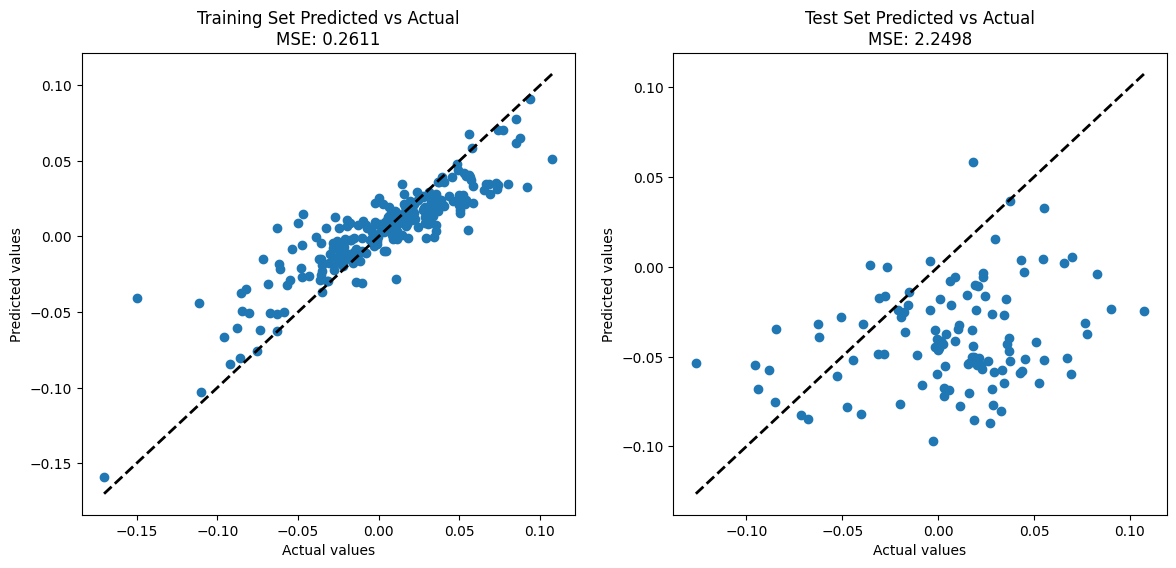

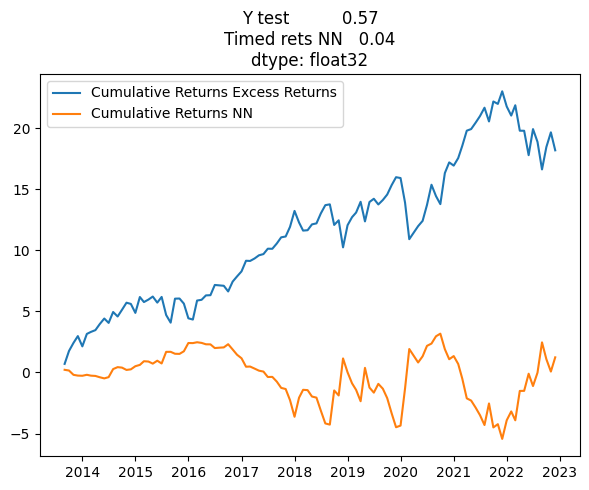


Depth: [512, 256, 128, 64]
Learning rate: 0.0001
Weight decay: 0



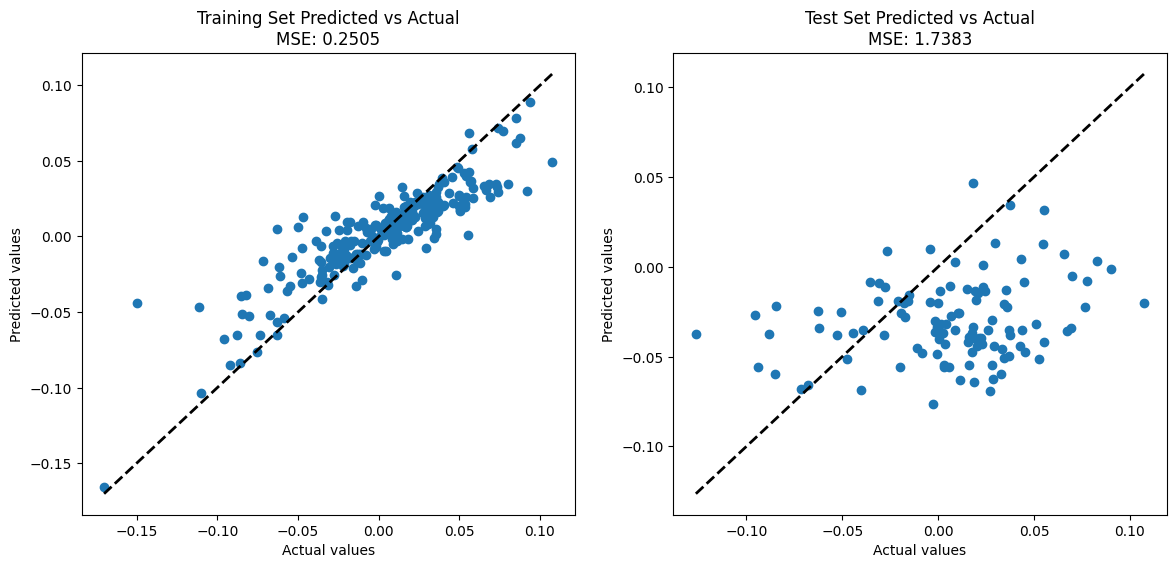

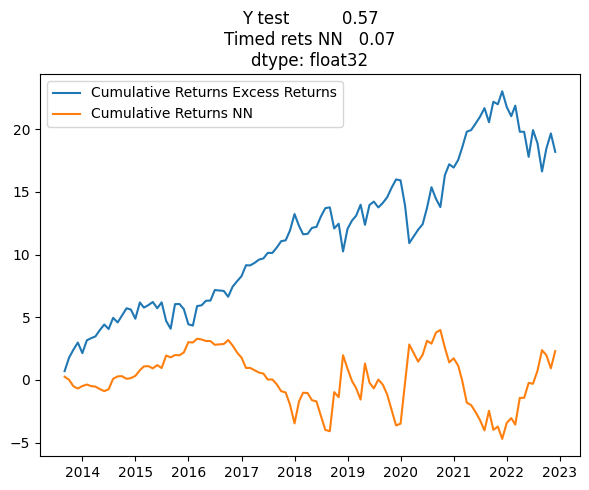


Depth: [512, 256, 128, 64, 32]
Learning rate: 0.0001
Weight decay: 0



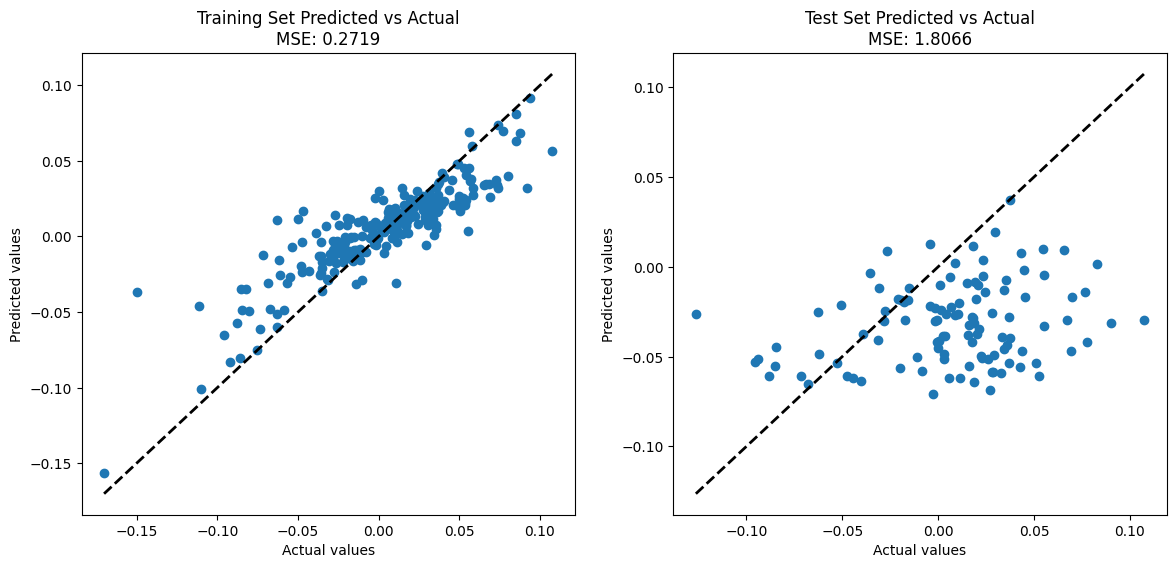

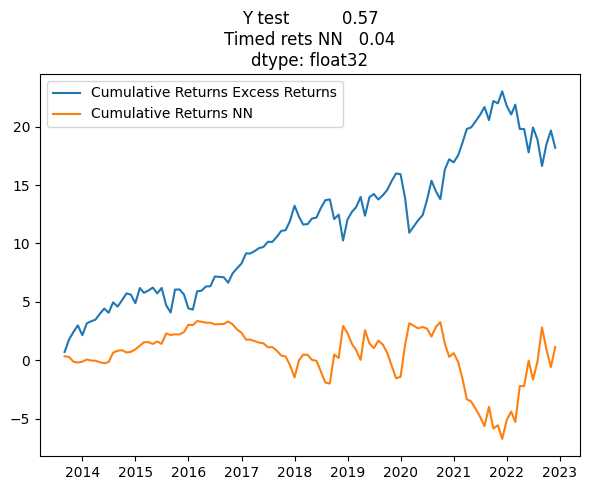


Depth: [512, 256, 128, 64, 32, 16]
Learning rate: 0.0001
Weight decay: 0



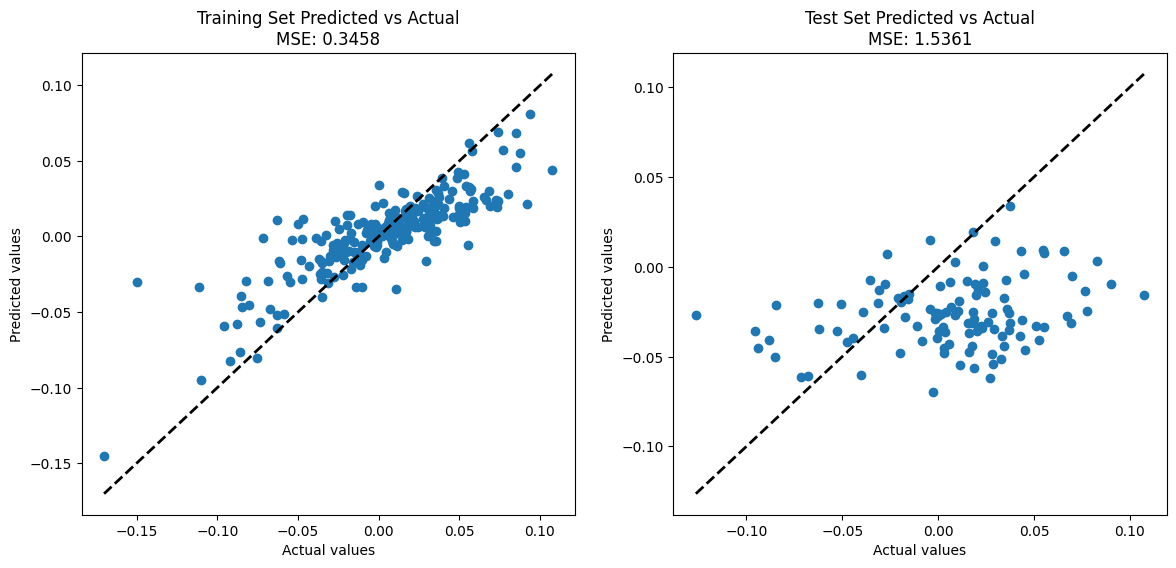

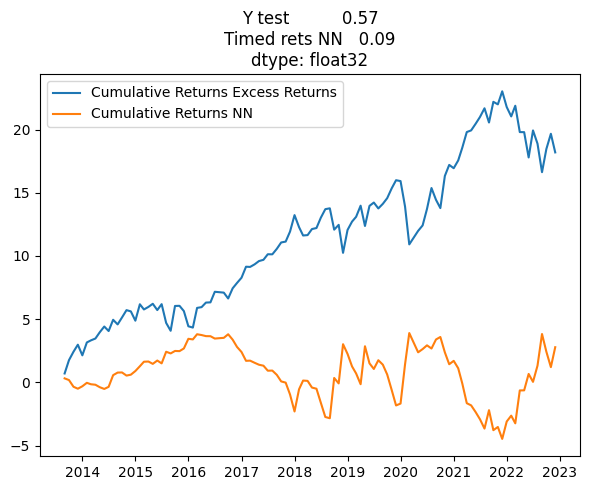

In [ ]:
# Neural Network parameters
lr = 0.0001       # Learning rate
weight_decay = 0
cut = 0.7

# List to store our results
sr_NN4 = []
train_mse4 = []
test_mse4 = []
res_NN4 = {}


# Number of layers with decreasing number of neurons tested
depth_range = [[512],[512, 256], [512,256,128], [512,256,128,64], [512,256,128,64,32], [512,256,128,64,32,16]]

# Running the neural network for each learning rate
for i, depth in enumerate(depth_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN4[i] = market_timing_returns


  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN4.append(sr)
  train_mse4.append(np.round(train_mse,2))
  test_mse4.append(np.round(test_mse, 2))


In [ ]:
# Concatenating the results
df_7030_decr = pd.concat([pd.DataFrame(train_mse4).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse4).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN4).T])
df_7030_decr.rename(columns = {0: 1, 1:2, 2:3, 3:4, 4:5, 5:6}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_7030_decr

1     2    3    4    5    6
Train MSE         0.47  0.31 0.26 0.25 0.27 0.35
Test MSE          1.56  2.97 2.25 1.74 1.81 1.54
Excess returns SR 0.57  0.57 0.57 0.57 0.57 0.57
Model predict SR  0.02 -0.07 0.04 0.07 0.04 0.09

**Observations**: case where each new layer has a decreased number of neurons

- Compared with the static number of neurons model, overall it has a higher test MSE
- Compared to all previous models, it has a much lower Sharpe Ratio

Hence, these parameters (70/30 split and decreasing number of neurons) do not seem appropriate for our dataset across various numbers of layers.

### **Learning rate**

Based on the results of the previous section, we stick to a 50-50 train-test split and a Neural Network of 1 layer with 512 neurons. <br>
We now move on to test different learning rates.




Depth: [512]
Learning rate: 1
Weight decay: 0



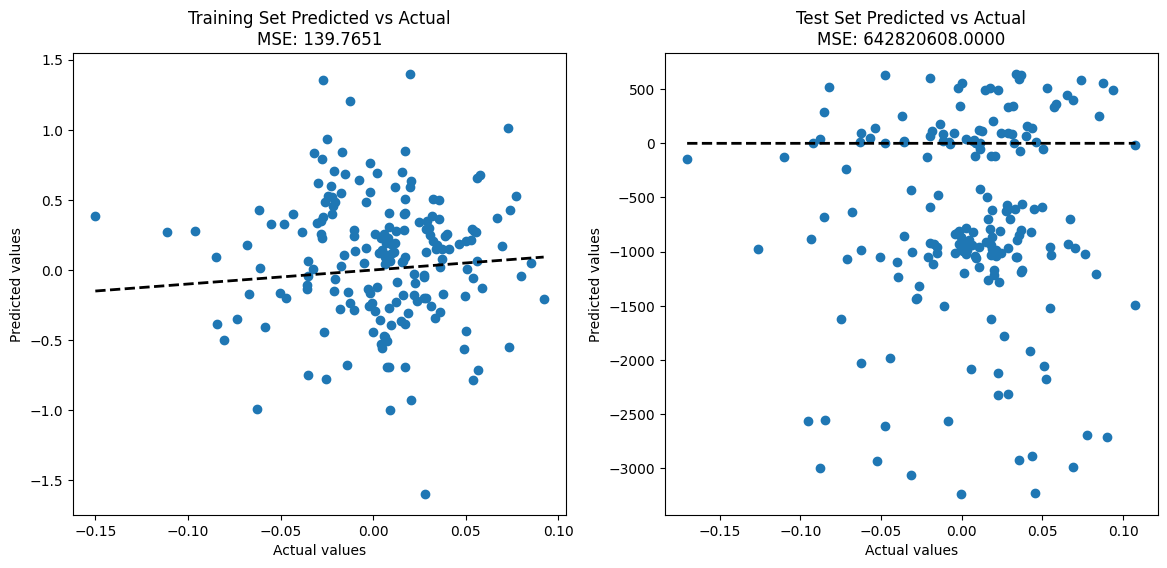

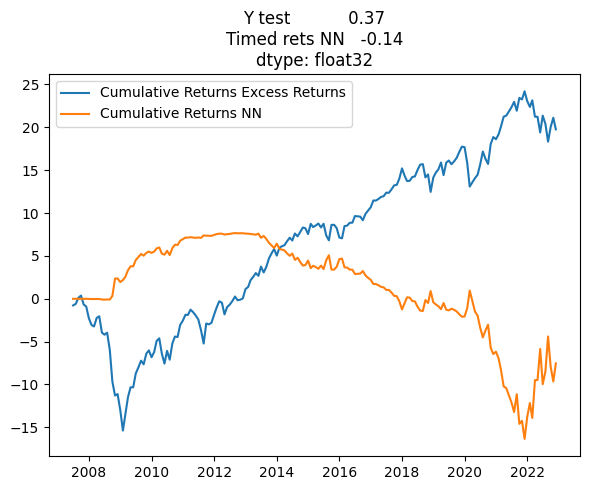


Depth: [512]
Learning rate: 0.1
Weight decay: 0



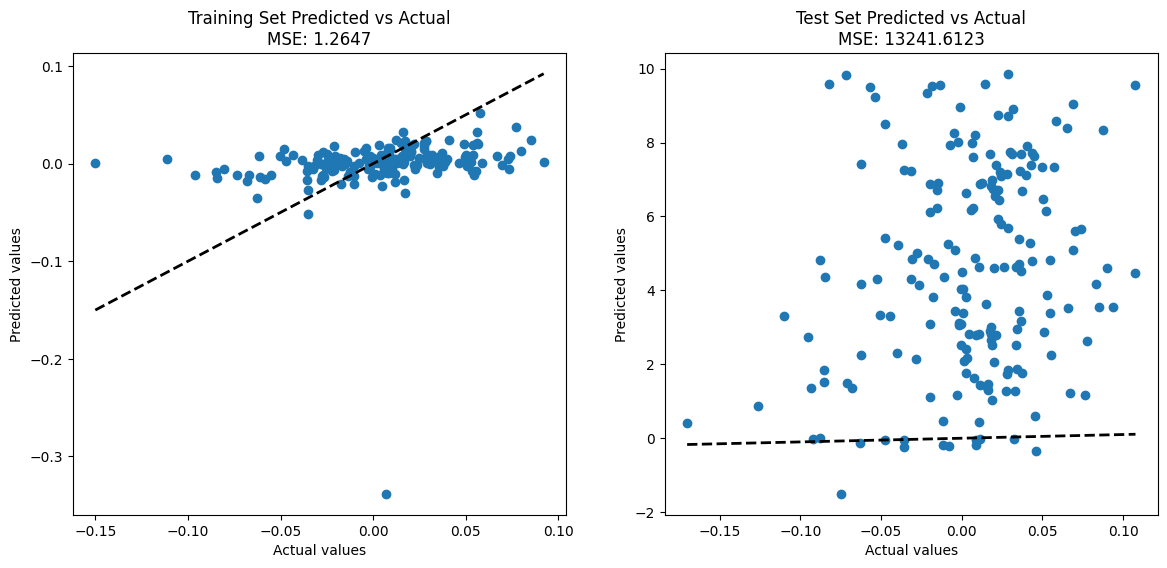

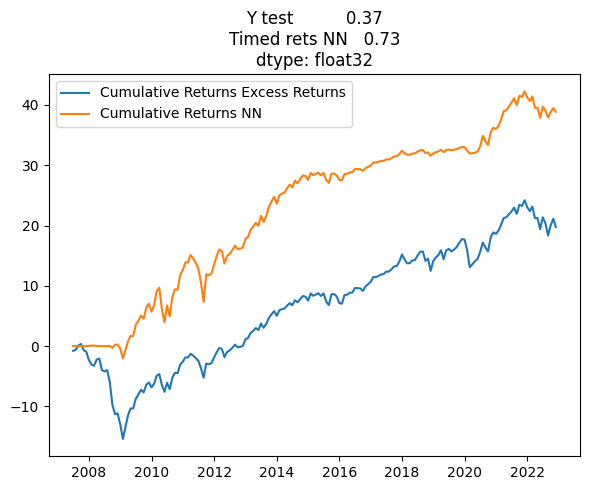


Depth: [512]
Learning rate: 0.01
Weight decay: 0



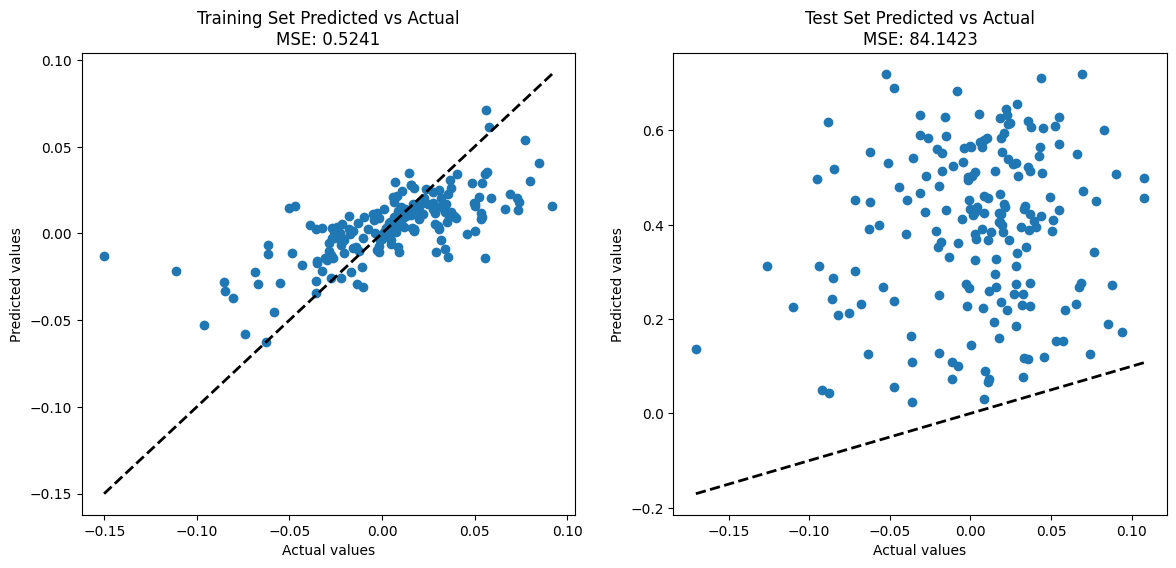

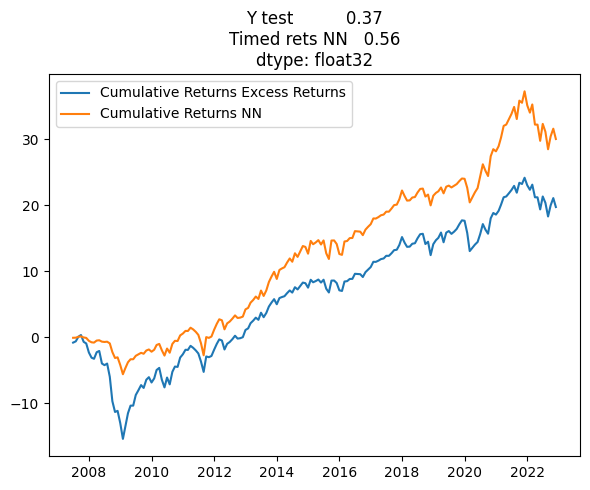


Depth: [512]
Learning rate: 0.001
Weight decay: 0



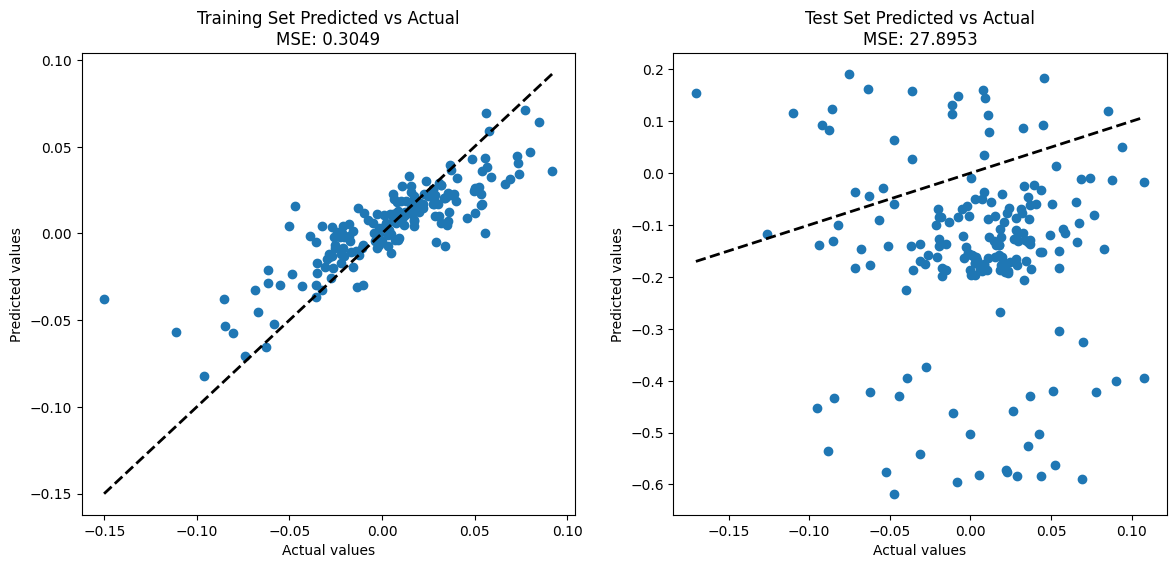

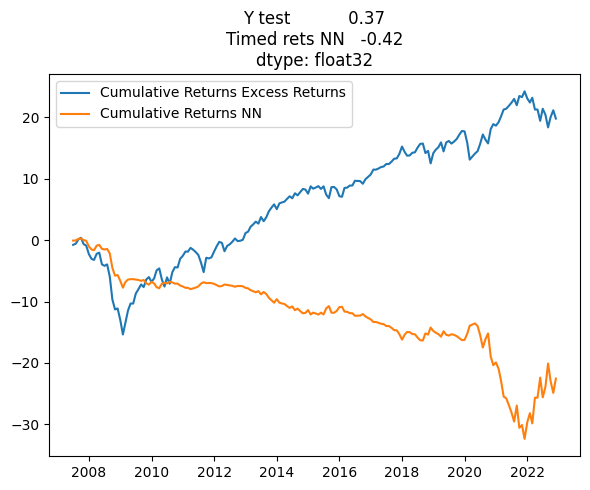


Depth: [512]
Learning rate: 0.0001
Weight decay: 0



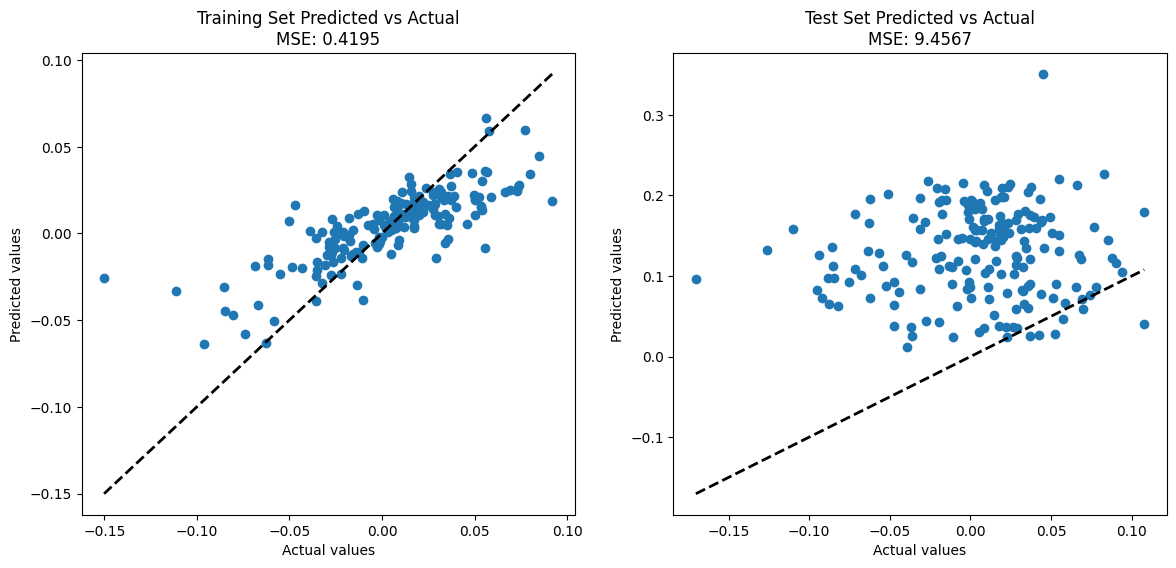

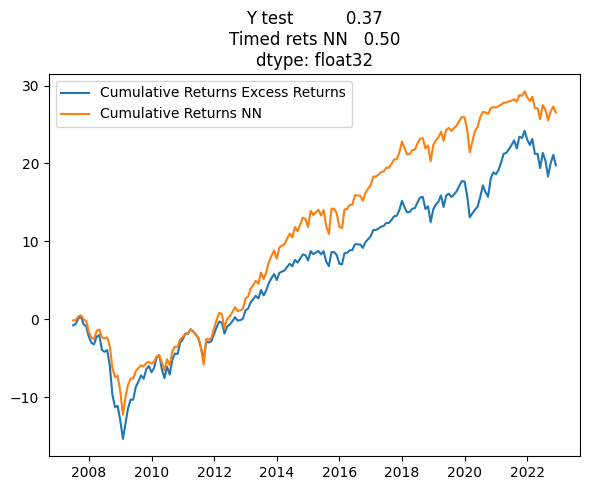


Depth: [512]
Learning rate: 1e-05
Weight decay: 0



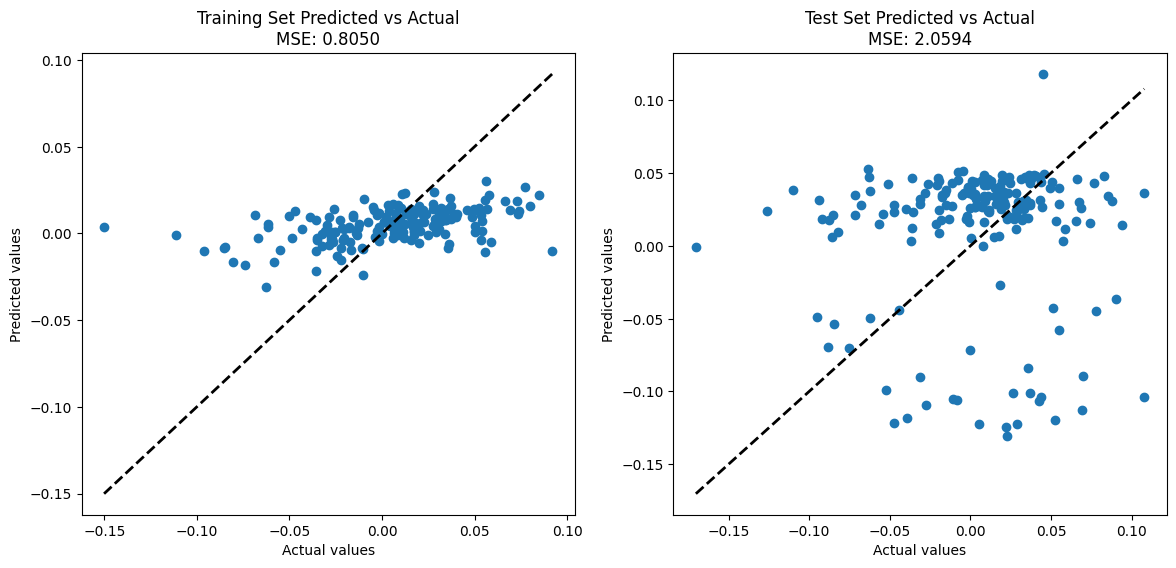

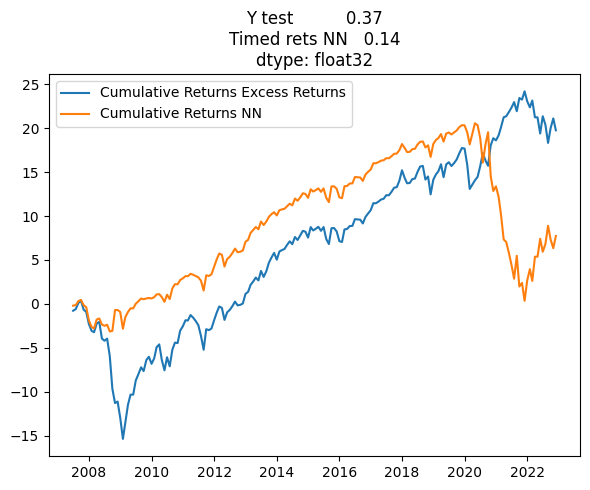


Depth: [512]
Learning rate: 1e-06
Weight decay: 0



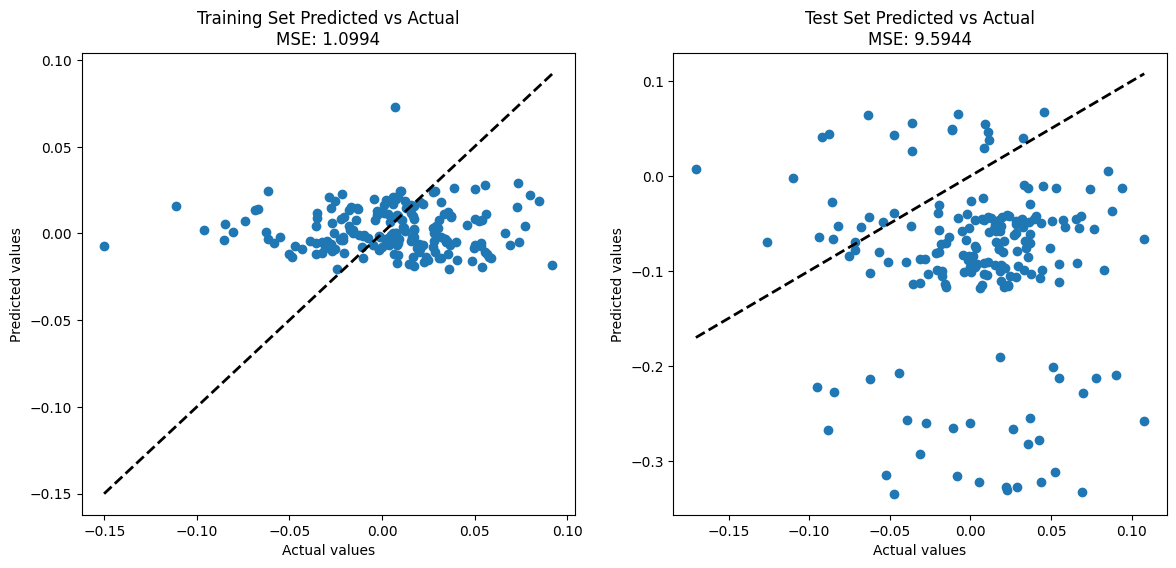

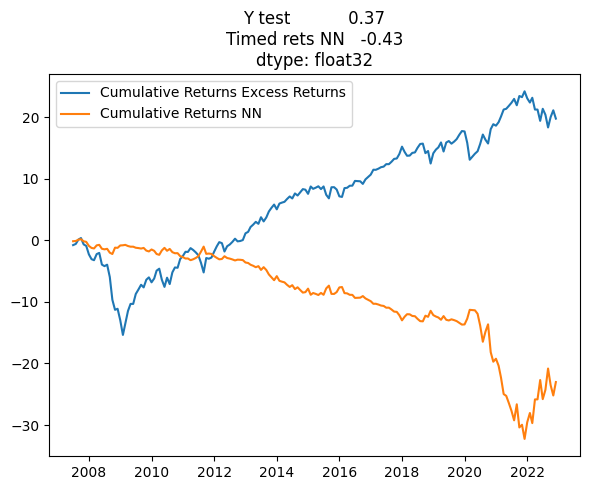

In [ ]:
# Neural Network parameters
depth = [512]
weight_decay = 0
cut = 0.5

# List to store our results
sr_NN5 = []
train_mse5 = []
test_mse5 = []
res_NN5 = {}

# Learning rates tested
lr_range = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

# Running the neural network for each learning rate
for i, lr in enumerate(lr_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN5[i] = market_timing_returns


  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN5.append(sr)
  train_mse5.append(np.round(train_mse,2))
  test_mse5.append(np.round(test_mse, 2))

In [ ]:
# Concatenating the results
df_5050_lr = pd.concat([pd.DataFrame(train_mse5).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse5).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN5).T])
df_5050_lr.rename(columns = {0: '1', 1:'0.1', 2:'0.01', 3:'0.001', 4:'0.0001', 5:'1e-05', 6:'1e-06'}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_5050_lr

1       0.1  0.01  0.001  0.0001  1e-05  1e-06
Train MSE                 139.77      1.26  0.52   0.30    0.42   0.80   1.10
Test MSE          642,820,608.00 13,241.61 84.14  27.90    9.46   2.06   9.59
Excess returns SR           0.37      0.37  0.37   0.37    0.37   0.37   0.37
Model predict SR           -0.14      0.73  0.56  -0.42    0.50   0.14  -0.43

**Observations**:
- Both the train and test MSE decrease as we decrease the learning rate from 1 to 1e-06. There is however a spike when lr=1e-06 for the test MSE, and an increase of the train MSE when lr=1e-05 and lr=1e-06.
- The performance is unstable with the decreasing learning rate : the SR first increases to 0.73, before decreasing to -0.42, then increasing again to 0.5 and ending down at -0.43. The strategy underperforms in 4 out of the 7 instances.

Based on the trade-off between the Sharpe ratio and MSE, we obtain the best performance when the learning rate is set at 0.0001.

In [ ]:
# Comparing the model predictions with excess returns

left = pd.DataFrame(res_NN5[4])  # model with lr = 0.0001
right = res_RF[1]["excess_returns"]

t_stat = regression_with_tstats(predicted_variable = left, explanatory_variables = right)["excess_returns"]
print("T-statistic is : ", t_stat)

T-statistic is :  13.1


**Observation**:
- With learning rate lr = 0.0001, the model significantly outperforms the Excess returns.

### **Weight decay**
We now study the impact of different weight decay rates. We use a learning rate equal to $10^{-4}$ based on the results of the previous section.


Depth: [512]
Learning rate: 0.0001
Weight decay: 0



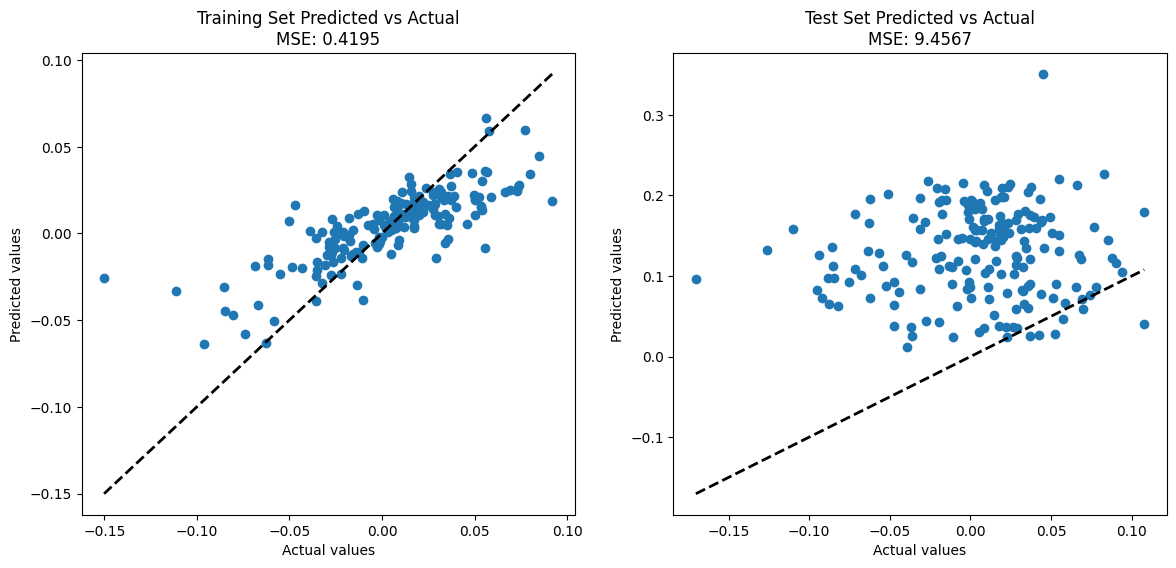

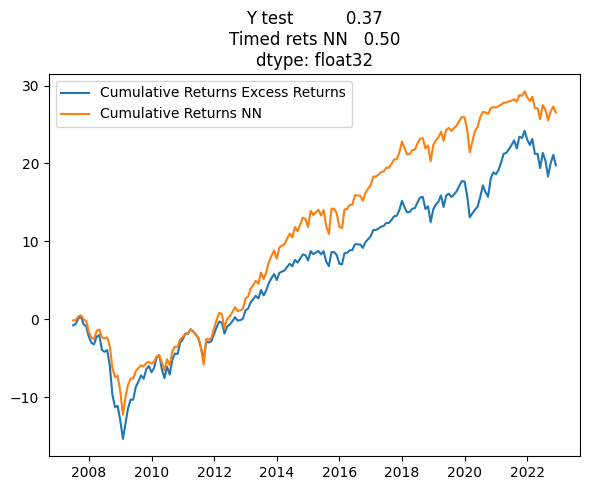


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.05



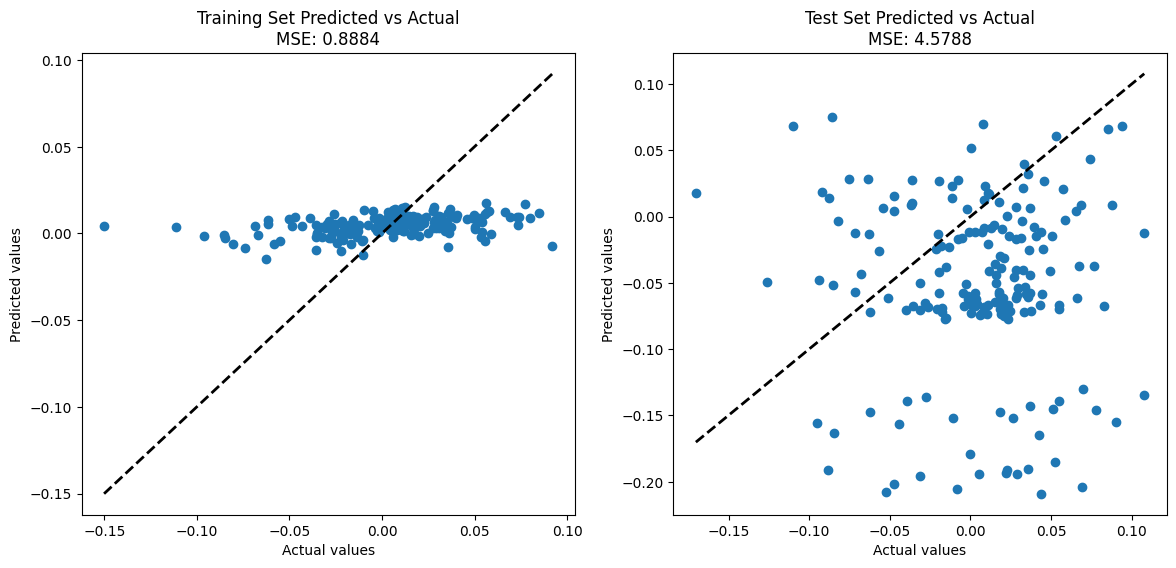

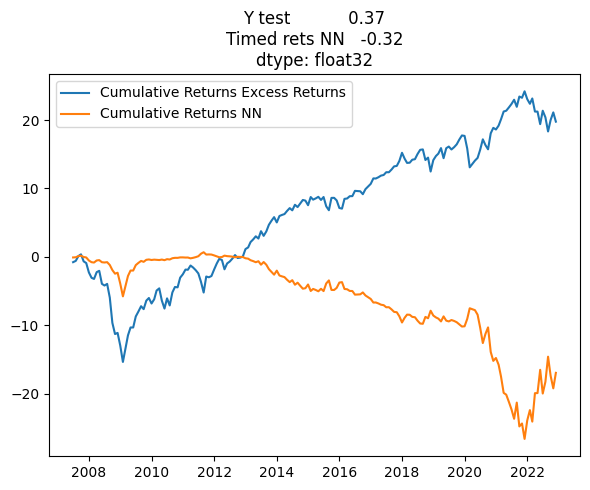


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.15



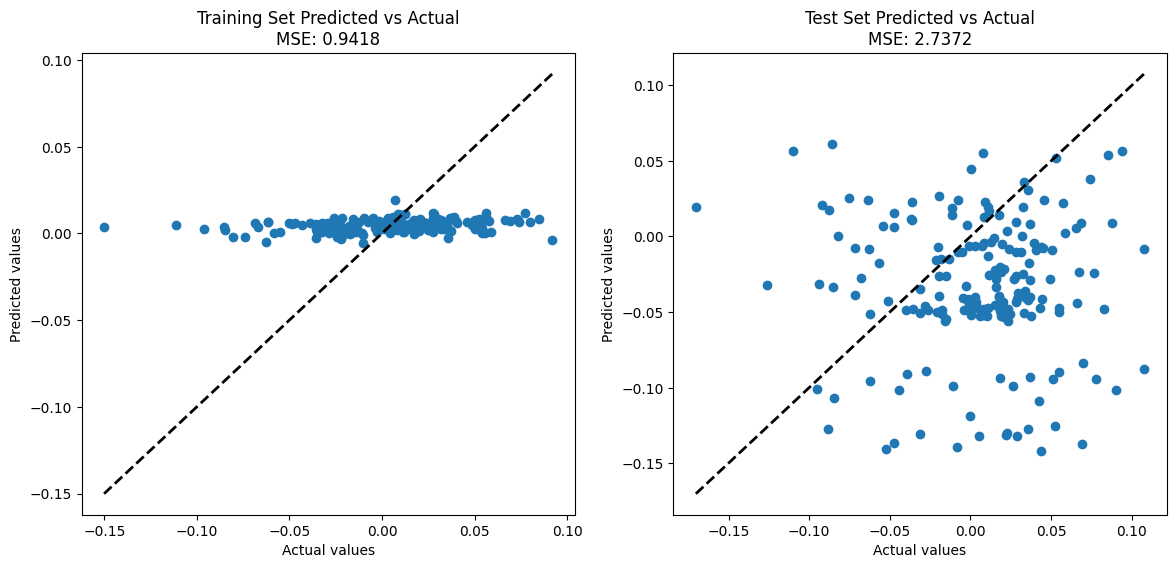

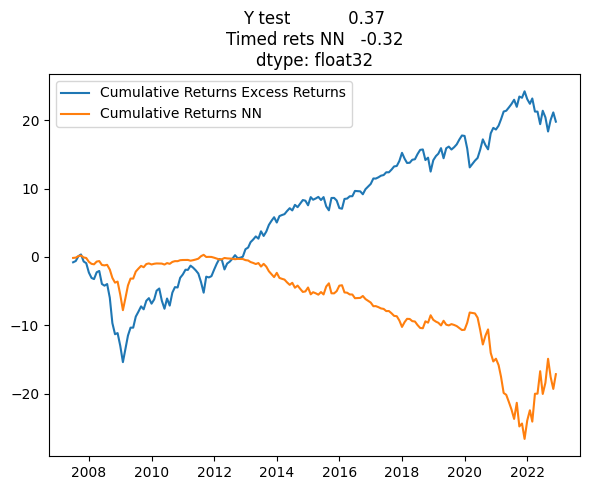


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.3



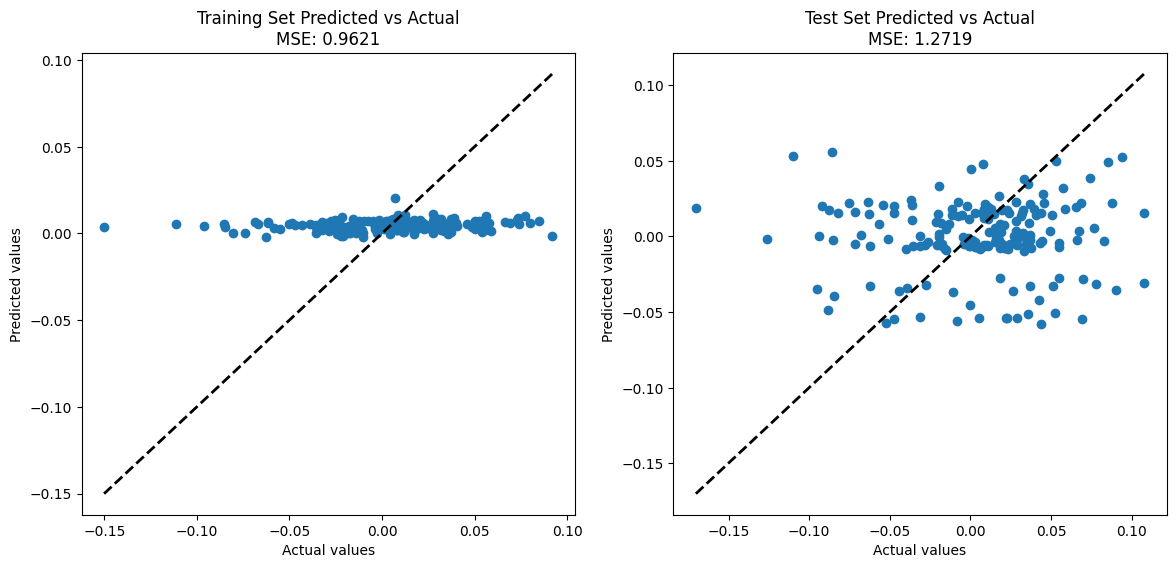

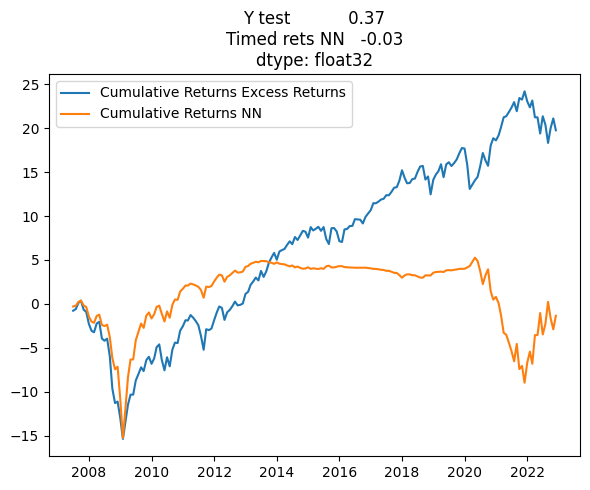


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.5



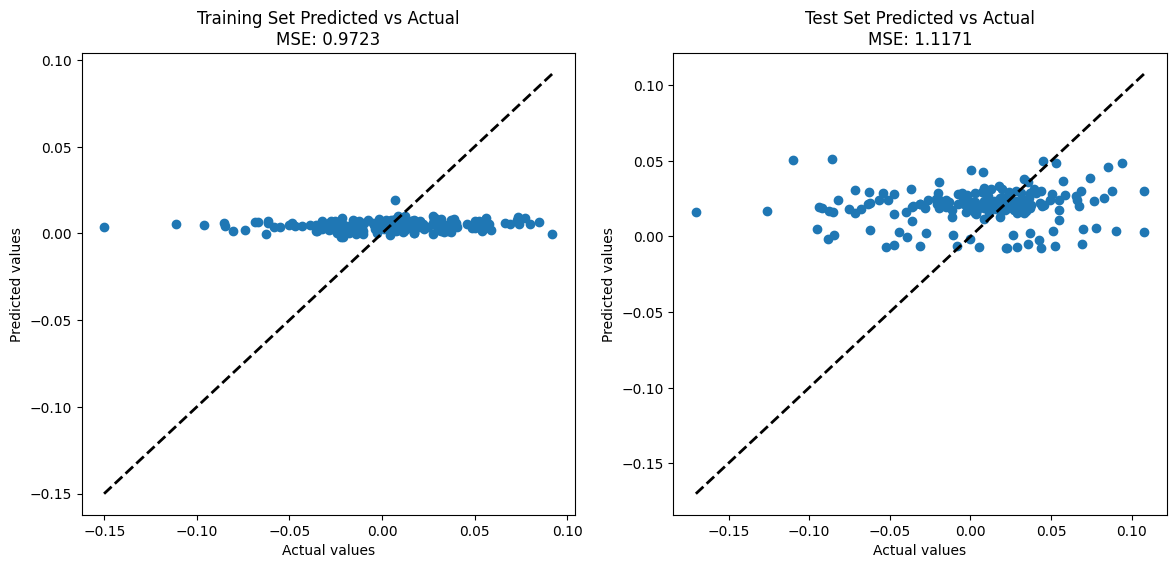

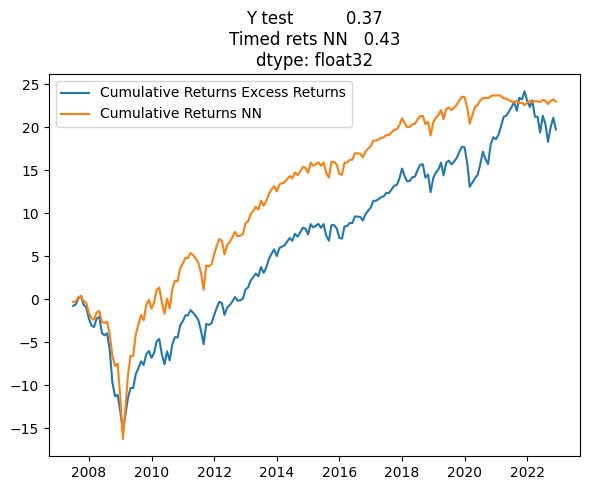


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.7



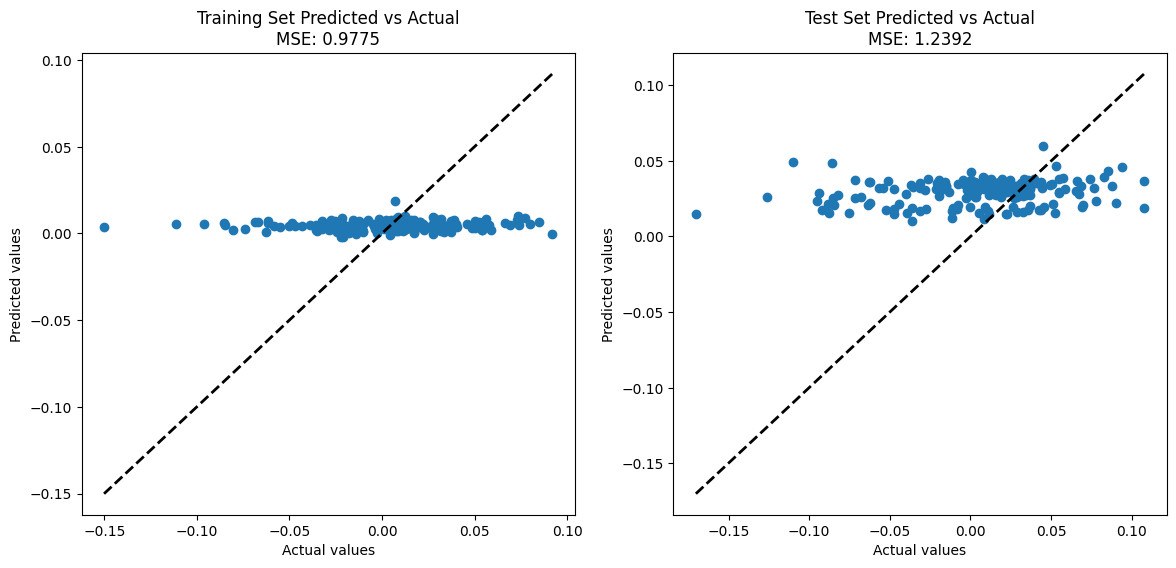

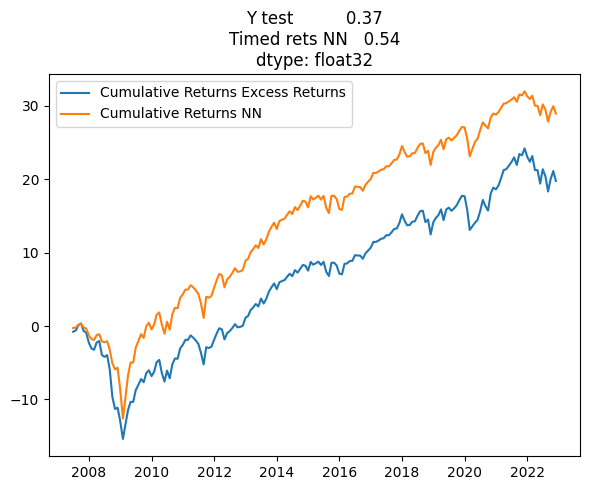


Depth: [512]
Learning rate: 0.0001
Weight decay: 0.9



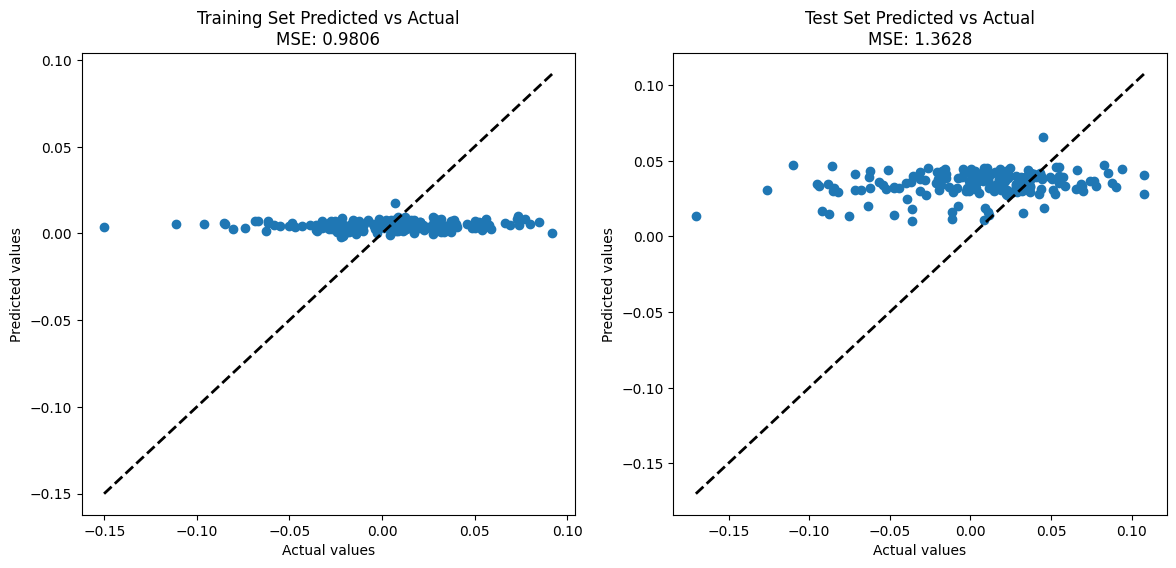

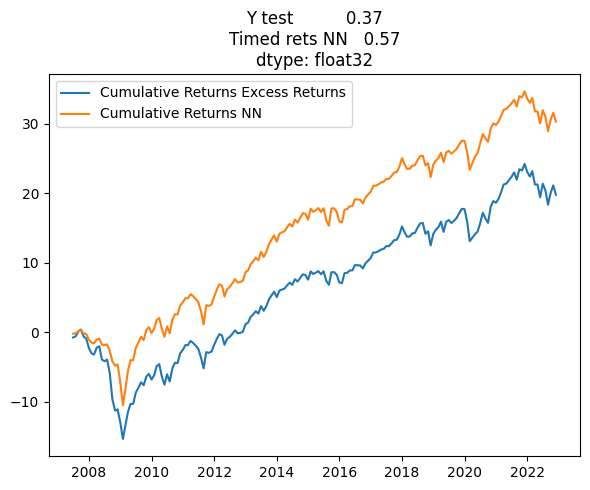

In [ ]:
# Neural Network parameters (100 neurons, 6 layers, 50-50 split)
depth = [512]
lr = 0.0001
cut = 0.5

# List to store our results
sr_NN6 = []
train_mse6 = []
test_mse6 = []
res_NN6 = {}

# Different rates of weight decay tested
weight_decay_range = [0, 0.05, 0.15, 0.30, 0.5, 0.7, 0.9]

# Running the neural network for the all the rates of weight decay
for i, weight_decay in enumerate(weight_decay_range):

  train, test, dates = split_norm_data(cut)
  train_predictions, train_targets, test_predictions, test_targets = neural_net(depth, lr, weight_decay, train, test)

  market_timing_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
  res_NN6[i] = market_timing_returns


  # Printing and plotting the results
  print(f"\nDepth: {depth}\nLearning rate: {lr}\nWeight decay: {weight_decay}\n")

  sr, train_mse, test_mse = plot_NN(train_predictions, train_targets, test_predictions, test_targets,dates)

  # Storing the results for further analysis
  sr_NN6.append(sr)
  train_mse6.append(np.round(train_mse,2))
  test_mse6.append(np.round(test_mse, 2))

In [ ]:
# Concatenating the results
df_5050_wd = pd.concat([pd.DataFrame(train_mse6).T.rename(index = {0: "Train MSE"}),
                        pd.DataFrame(test_mse6).T.rename(index = {0: "Test MSE"}),
                          pd.DataFrame(sr_NN6).T])

df_5050_wd.rename(columns = {0: 0, 1:0.05, 2:0.15, 3:0.30, 4:0.50, 5:0.70, 6:0.90}, index={'Y test': 'Excess returns SR', 'Timed rets NN': 'Model predict SR'}, inplace=True)

# Displaying the results
df_5050_wd

0.00  0.05  0.15  0.30  0.50  0.70  0.90
Train MSE          0.42  0.89  0.94  0.96  0.97  0.98  0.98
Test MSE           9.46  4.58  2.74  1.27  1.12  1.24  1.36
Excess returns SR  0.37  0.37  0.37  0.37  0.37  0.37  0.37
Model predict SR   0.50 -0.32 -0.32 -0.03  0.43  0.54  0.57

**Observations**:
- The train MSE increases as we increase the weight decay.
- The test MSE decreases up to a certain level (weight decay = 0.5), then starts increasing again. This decrease makes sense since weight decay consists in adding a penalty term to the loss function during training, which discourages the model from learning overly complex patterns that may fit the training data too closely. The later increase could be attributed to the possibility that excessively high penalization may result in the omission of certain information during fitting.
- Not taking into account the case where the weight decay is 0, increasing the weight decay generally leads to a higher SR.

### **Conclusion**

Overall, from our analysis we can observe that:
- Increasing the depth of our model generally decreases the MSE in both train and test datasets as it becomes more complex and better fits the patterns in the data. However, similar performance can be achieved with a smaller depth but a larger number of neurons.
- Increasing the train dataset may lead to overfitting.
- A lower learning rate generally reduces the MSE, but a too low learning rate can drastically decrease performance. This may be due to the fact that the gradient descent gets stuck in a local minimum. A too high learning rates overshoots the potential global minimum.
- The weight decay is a regularization technique that prevents the neural network from overfitting the training dataset. Adding a higher penalty may lead to a lower MSE and a better performance, especially for complex data.

